# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Постановка задачи

**Цель проекта** - определить клиентов, которые собираются уйти.


Для этого необходимо:
1. Изучить данные и выбрать метрику.
2. Выделить важные признаки и обозначить целевой.
3. Нормализовать и масштабировать численные признаки, закодировать категориальные.
4. Обучить несколько моделей классификации, посмотреть результат, подобрать гиперпараметры для лучшей модели.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
import pandas as pd
import numpy as np

#Для графиков
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(context='talk', style='whitegrid', palette='muted')
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

#Q-Q-plot
import statsmodels.api as sm

#Для поиска категориальных столбцов
from pandas.api.types import is_categorical_dtype

#Для расчёта кореляции категориальных признаков
from scipy.stats import chi2_contingency

#Для определения важности признаков
from sklearn.feature_selection import mutual_info_classif

#Для подготовки числовых и категориальных признаков
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, QuantileTransformer

#Для создания новых признаков
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Для выделения тестовой выборки
from sklearn.model_selection import train_test_split

#Модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#Для поиска гиперпараметров и оценки моделей
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

#Для борьбы с дисбалансом
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

#Метрики
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

#random_state
RS = 81

## Анализ данных

Загрузим таблицы и посмотрим на них.

In [2]:
# link = '/datasets/final_provider/'
link = ''

df_names = [
    'contract',
    'personal',
    'internet',
    'phone'
]
df = {}

for df_name in df_names:
    df[df_name] = pd.read_csv(link + df_name + '.csv')
    display(df[df_name].sample(5, random_state=RS))
    print(df[df_name].info())

customerID   BeginDate              EndDate            Type  \
4712  7550-WIQVA  2015-12-01                   No        One year   
5826  9507-EXLTT  2019-09-01  2019-10-01 00:00:00  Month-to-month   
3309  6061-PQHMK  2018-01-01                   No        One year   
905   0781-LKXBR  2019-02-01  2019-11-01 00:00:00  Month-to-month   
5591  7228-OMTPN  2019-08-01  2019-12-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
4712              Yes           Electronic check          108.25       5431.4  
5826              Yes  Bank transfer (automatic)           79.35        79.35  
3309               No    Credit card (automatic)           19.90        527.5  
905               Yes           Electronic check          100.50        918.6  
5591              Yes           Electronic check           88.45       370.65

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


customerID  gender  SeniorCitizen Partner Dependents
4712  7550-WIQVA    Male              0     Yes        Yes
5826  9507-EXLTT  Female              0     Yes         No
3309  6061-PQHMK  Female              0      No         No
905   0781-LKXBR    Male              1      No         No
5591  7228-OMTPN    Male              0      No         No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
3366  8908-NMQTX             DSL            Yes          Yes              Yes   
1251  1205-WNWPJ             DSL             No           No               No   
2315  7410-YTJIK     Fiber optic             No           No               No   
2798  6080-TCMYC     Fiber optic             No           No              Yes   
5377  8065-QBYTO     Fiber optic            Yes          Yes               No   

     TechSupport StreamingTV StreamingMovies  
3366         Yes         Yes             Yes  
1251         Yes         Yes              No  
2315          No          No              No  
2798          No          No              No  
5377         Yes         Yes              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


customerID MultipleLines
4791  7399-QHBJS           Yes
2882  7272-QDCKA           Yes
3916  4369-NYSCF            No
828   6513-EECDB           Yes
1534  9225-BZLNZ           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


В таблицах представлены следующие данные:

1. **contract** — информация о договоре

- *customerID* - уникальный код клиента
- *BeginDate* - дата заключения договора
- *EndDate* - дата расторжения договора
- *Type* - тип оплаты: ежемесячная или за год/два
- *PaperlessBilling* - электронный счёт на оплату (не бумажный): да/нет
- *PaymentMethod* - способ оплаты
- *MonthlyCharges* - оплата в месяц
- *TotalCharges* - оплачено всего
       
2. **personal** — персональные данные клиента

- *customerID* - уникальный код клиента
- *gender* - пол
- *SeniorCitizen* - является ли пенсионером
- *Partner* - есть ли партнёр
- *Dependents* - есть ли иждивенцы

3. **internet** — информация об интернет-услугах

- *customerID* - уникальный код клиента
- *InternetService* - тип интернета: DSL или оптика
- *OnlineSecurity* - дополнительна услуга: подключена/нет
- *OnlineBackup* - дополнительна услуга: подключена/нет
- *DeviceProtection* - дополнительна услуга: подключена/нет
- *TechSupport* - дополнительна услуга: подключена/нет
- *StreamingTV* - дополнительна услуга: подключена/нет
- *StreamingMovies* - дополнительна услуга: подключена/нет
       
4. **phone** — информация об услугах телефонии

- *customerID* - уникальный код клиента
- *MultipleLines* - подключен ли телефон к нескольким линиям


В таблицах нет пропусков, однако в столбце TotalCharges таблицы contract тип данных определился как object, хотя по смыслу должен быть float.

В таблицах разное количество строк. Не для всех клиентов есть информация об используемых интернетах-услугах и услугах телефонии. Возможно, это потому что не все клиенты пользуется этими услугами.

Необходимо:

1. Проверить, что все customerID уникальны, и установить их в качестве индекса.
2. Привести тип данных TotalCharges к числовому.
3. Создать признак *Exited* - клиент ушёл.
4. Создать признак *Tenure* - сколько месяцев является клиентом (на момент 1 февраля 2020).
5. Даты представить как даты.
6. Для всех категориальных столбцов посмотреть варианты значений и привести к category.
7. Посмотреть на распределения числовых признаков.
8. Посмотреть, существуют ли клиенты, для которых вообще нет информации об услугах.

Столбец gender едиственный начинается с маленькой буквы - исправим это.

In [3]:
df['personal'] = df['personal'].rename(columns={'gender': 'Gender'})

Проверим уникальность ID.

In [4]:
for df_name in df_names:
    print('{}: {} уникальных ID из {}'.format(
        df_name, df[df_name]['customerID'].nunique(), df[df_name].shape[0]
    ))

contract: 7043 уникальных ID из 7043
personal: 7043 уникальных ID из 7043
internet: 5517 уникальных ID из 5517
phone: 6361 уникальных ID из 6361


Все ID уникальны, используем их в качестве индексов.

In [5]:
for df_name in df_names:
    df[df_name] = df[df_name].set_index('customerID')

Перейдём к TotalCharges. Удалим значения, которые мешают столбцу быть числовым.

In [6]:
df['contract']['TotalCharges'] = pd.to_numeric(df['contract']['TotalCharges'], errors='coerce')
df['contract'][df['contract']['TotalCharges'].isna()]

BeginDate EndDate      Type PaperlessBilling  \
customerID                                                  
4472-LVYGI  2020-02-01      No  Two year              Yes   
3115-CZMZD  2020-02-01      No  Two year               No   
5709-LVOEQ  2020-02-01      No  Two year               No   
4367-NUYAO  2020-02-01      No  Two year               No   
1371-DWPAZ  2020-02-01      No  Two year               No   
7644-OMVMY  2020-02-01      No  Two year               No   
3213-VVOLG  2020-02-01      No  Two year               No   
2520-SGTTA  2020-02-01      No  Two year               No   
2923-ARZLG  2020-02-01      No  One year              Yes   
4075-WKNIU  2020-02-01      No  Two year               No   
2775-SEFEE  2020-02-01      No  Two year              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  
customerID                                                           
4472-LVYGI  Bank transfer (automatic)           52.55           NaN  
3115-CZMZD               Mailed check           20.25           NaN  
5709-LVOEQ               Mailed check           80.85           NaN  
4367-NUYAO               Mailed check           25.75           NaN  
1371-DWPAZ    Credit card (automatic)           56.05           NaN  
7644-OMVMY               Mailed check           19.85           NaN  
3213-VVOLG               Mailed check           25.35           NaN  
2520-SGTTA               Mailed check           20.00           NaN  
2923-ARZLG               Mailed check           19.70           NaN  
4075-WKNIU               Mailed check           73.35           NaN  
2775-SEFEE  Bank transfer (automatic)           61.90           NaN

Нечисловые значения TotalCharges были у клиентов, которые только заключили договор 1 февраля 2020 года и ещё ничего не успели заплатить. Такие клиенты непоказательны для решаемой задачи - удалим их из выборки.

In [7]:
df['contract'] = df['contract'].dropna()
df['contract'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7032 non-null   object 
 1   EndDate           7032 non-null   object 
 2   Type              7032 non-null   object 
 3   PaperlessBilling  7032 non-null   object 
 4   PaymentMethod     7032 non-null   object 
 5   MonthlyCharges    7032 non-null   float64
 6   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(5)
memory usage: 439.5+ KB


Создадим признак Exited - клиент ушёл.

In [8]:
df['contract']['Exited'] = (df['contract']['EndDate'] != 'No') * 1

Теперь можно заменить "No" в EndDate на 1 февраля 2020, чтобы было удобнее считать продолжительность пользования услугами.

In [9]:
df['contract']['EndDate'] = df['contract']['EndDate'].replace('No', '2020-02-01 00:00:00')
df['contract'].sample(5, random_state=RS)

BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
9479-HYNYL  2014-03-01  2020-02-01 00:00:00        Two year              Yes   
4072-IPYLT  2017-02-01  2020-02-01 00:00:00  Month-to-month               No   
3778-FOAQW  2018-02-01  2020-02-01 00:00:00        One year               No   
7459-IMVYU  2016-12-01  2020-02-01 00:00:00  Month-to-month               No   
6408-OTUBZ  2014-08-01  2020-02-01 00:00:00        One year              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  Exited  
customerID                                                                   
9479-HYNYL    Credit card (automatic)           80.70       5705.05       0  
4072-IPYLT    Credit card (automatic)           51.05       1815.00       0  
3778-FOAQW               Mailed check           20.15        456.85       0  
7459-IMVYU           Electronic check           69.95       2657.55       0  
6408-OTUBZ  Bank transfer (automatic)          104.55       6779.05       0

Изменим тип данных столбцов с датами на datetime.

In [10]:
for col in ['BeginDate','EndDate']:
    df['contract'][col] = pd.to_datetime(df['contract'][col], format='%Y-%m-%d')

Добавим признак Tenure - сколько месяцев является клиентом (на момент 1 февраля 2020).

In [11]:
df['contract']['Tenure'] = (
    (df['contract']['EndDate'] - df['contract']['BeginDate'])
    .astype('timedelta64[M]')
    .astype('int')
)

Проверим, что в результате не получилось отрицательных чисел, на случай, если в датах были ошибки.

In [12]:
(df['contract']['Tenure'] < 0).sum()

0

Проверим, что расчёт TotalCharges сходится с другими данными таблицы. Посмотрим на разницу TotalCharges и произведения MonthlyCharges и Tenure.

In [13]:
(
    (df['contract']['TotalCharges'] - df['contract']['Tenure'] * df['contract']['MonthlyCharges'])
    .to_frame(name='Delta')
    .join(df['contract'][['MonthlyCharges', 'TotalCharges', 'Tenure']])
    .head(10)
)

Delta  MonthlyCharges  TotalCharges  Tenure
customerID                                              
7590-VHVEG    0.00           29.85         29.85       1
5575-GNVDE  -46.80           56.95       1889.50      34
3668-QPYBK    0.45           53.85        108.15       2
7795-CFOCW  -62.75           42.30       1840.75      45
9237-HQITU   10.25           70.70        151.65       2
9305-CDSKC   23.30           99.65        820.50       8
1452-KIOVK  -10.80           89.10       1949.40      22
6713-OKOMC    4.40           29.75        301.90      10
7892-POOKP  111.65          104.80       3046.05      28
6388-TABGU    6.65           56.15       3487.95      62

Разница не равна нулю и при этом отличается от суммы за месяц. MonthlyCharges и TotalCharges противоречат друг другу. Возможно, клиенты платят не ровно по счёту, а с запасом, или наоборот забывают заплатить. Добавим признак Balance с отстатком средств клиента.

In [14]:
df['contract']['Balance'] = (
    df['contract']['TotalCharges'] - df['contract']['Tenure'] * df['contract']['MonthlyCharges']
)

Посмотрим на значения категориальных столбцов.

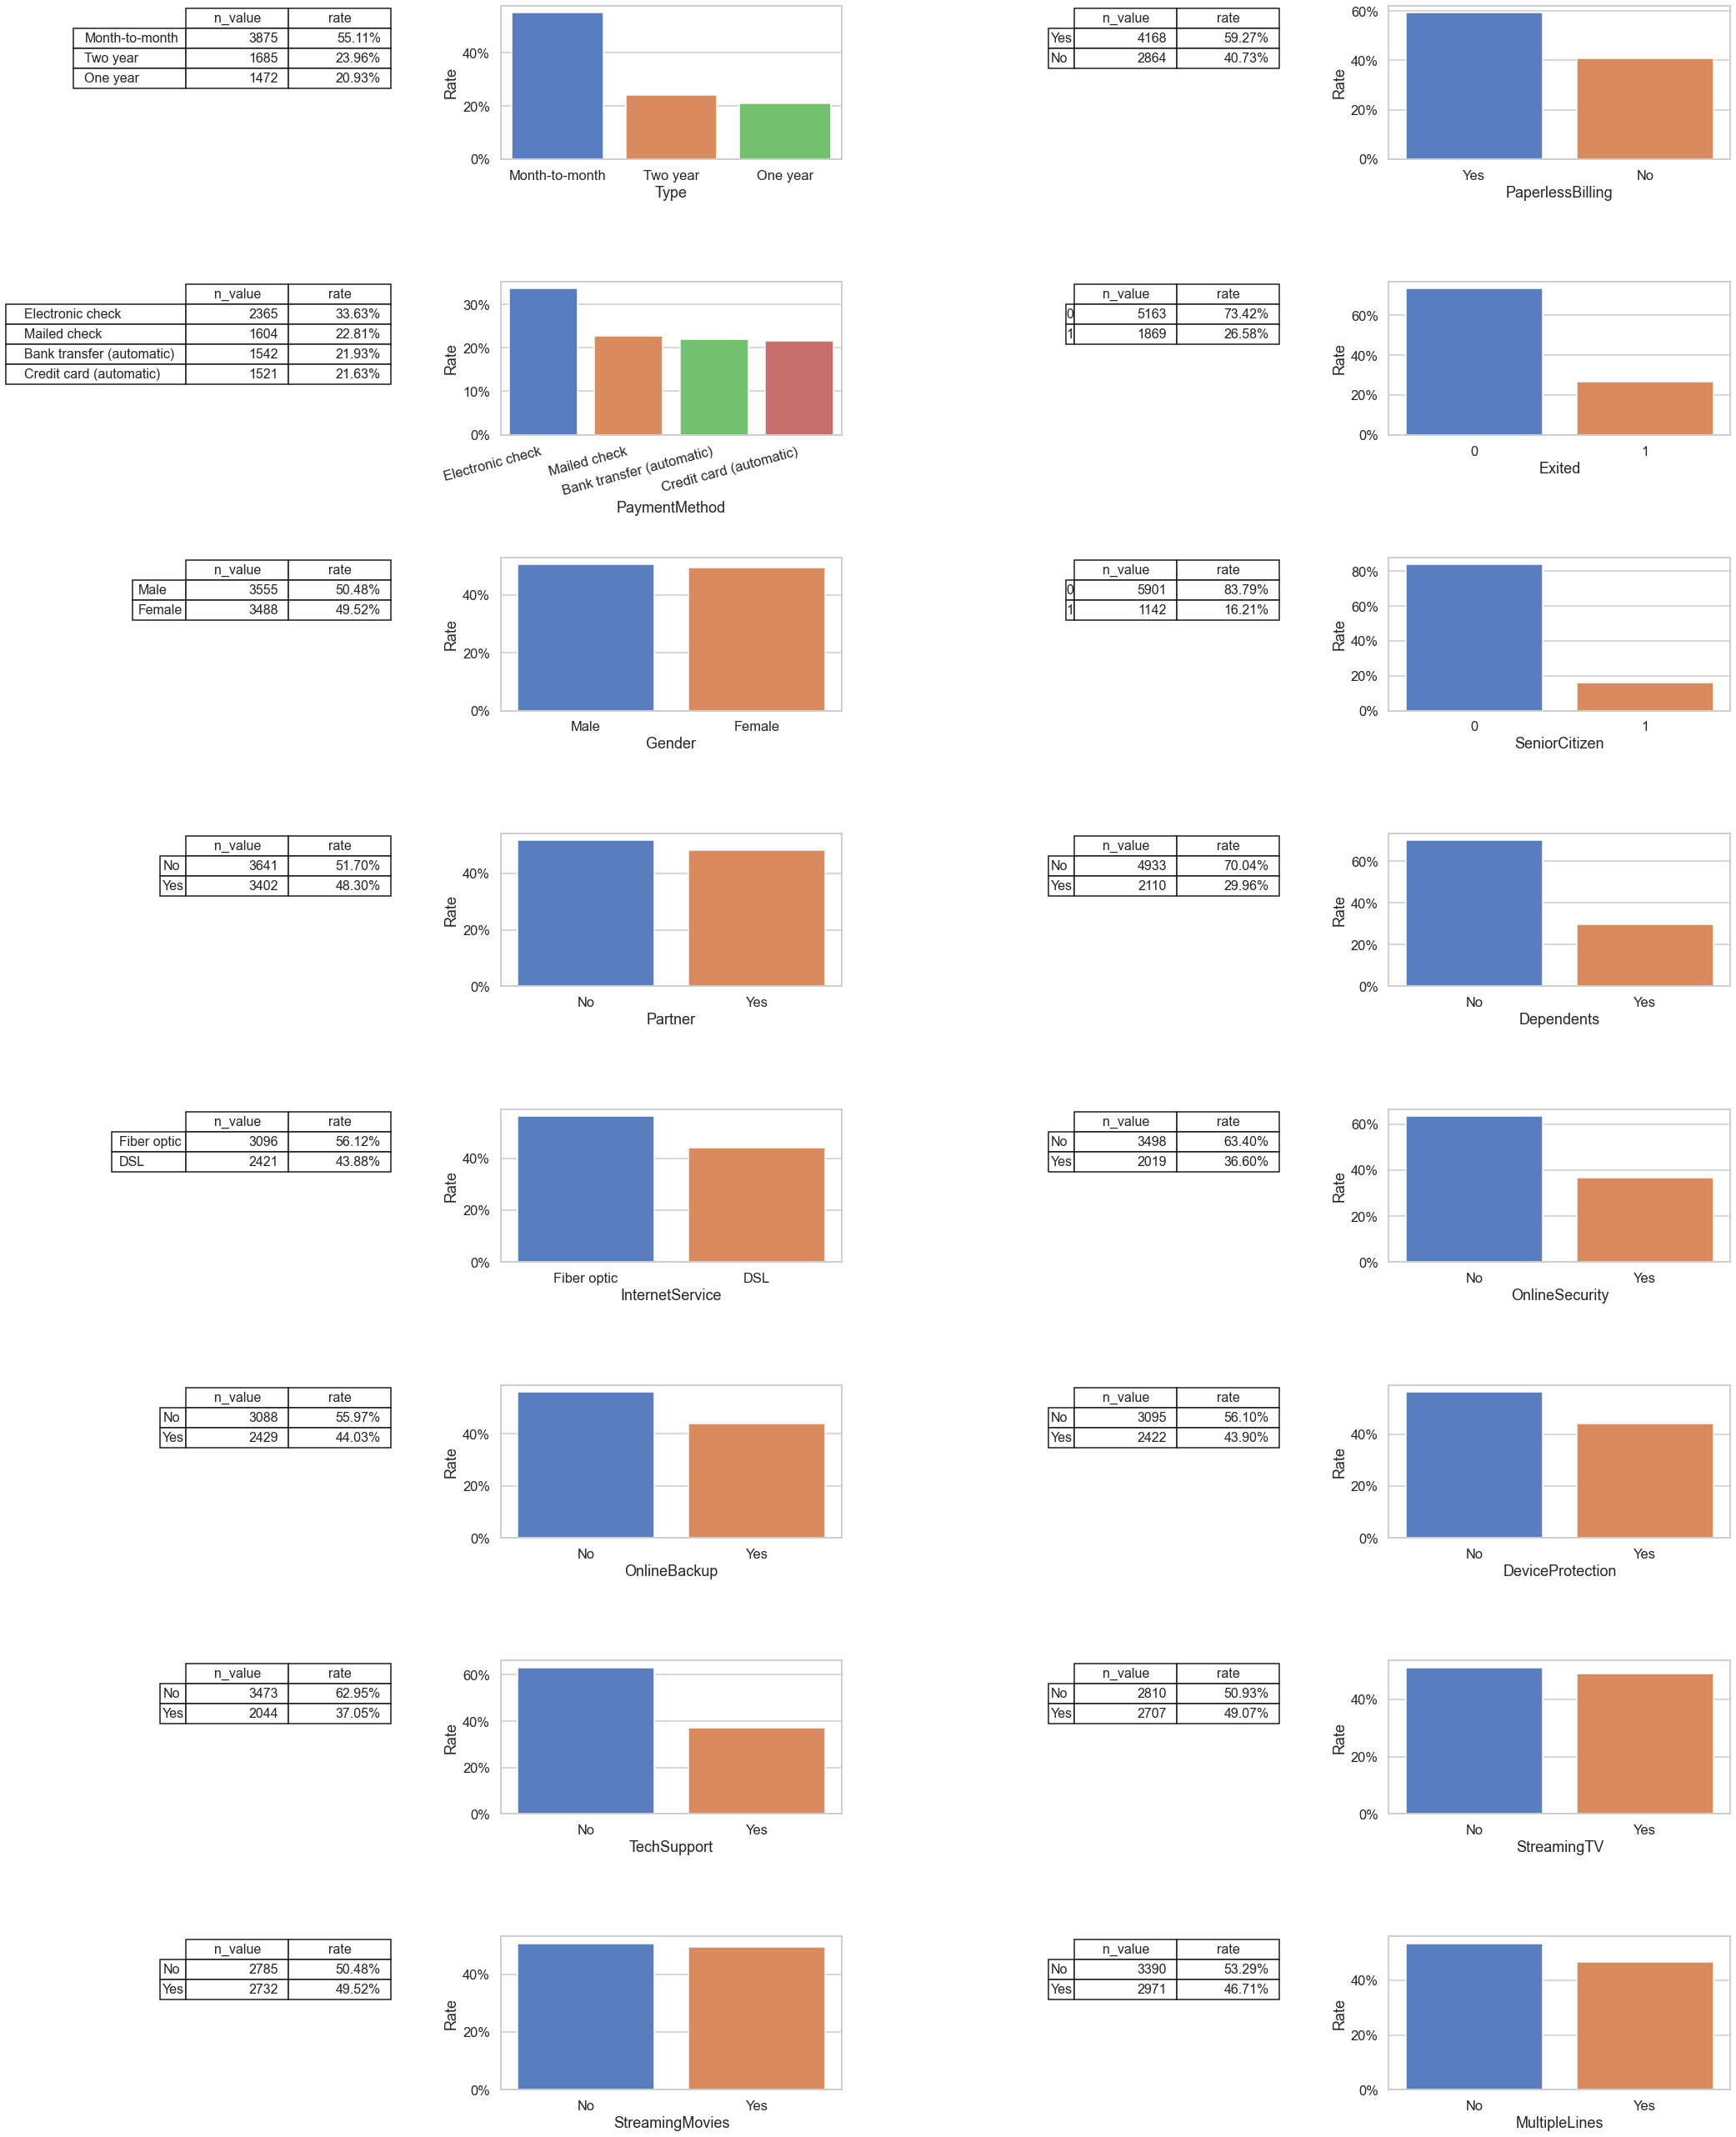

In [15]:
f, ax = plt.subplots(8, 4, gridspec_kw={'hspace': 0.8, 'wspace': 0.3})
f.set_figheight(46)
f.set_figwidth(36)

i = 0
for df_name in df_names:
    if df_name == 'contract':
        cat_cols = [col for col in df[df_name].columns if df[df_name][col].dtype == 'object'] + ['Exited']
    else:
        cat_cols = df[df_name].columns
        
    for col in cat_cols:
        ax_xy = [ax[i//2, i%2 * 2],ax[i//2, i%2 * 2 + 1]]
    
        df_col_values = df[df_name][col].value_counts().to_frame('n_value')
        df_col_values['rate'] = (df_col_values['n_value'] / df[df_name].shape[0]).map(lambda x: '{:.2%}'.format(x))

        the_table = ax_xy[0].table(
            #Содержимое таблицы в виде списка списков строк
            cellText = [list(x) for x in df_col_values.values.astype('str')],
            rowLabels = list(df_col_values.index),
            colLabels = list(df_col_values.columns),
            loc = 'upper right',
            colWidths = [0.3, 0.3]
        )
        the_table.scale(1, 2)
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(16)
        ax_xy[0].grid(False)
        ax_xy[0].axis('off')

        sns.barplot(
            x = df_col_values.index.astype('str'),
            y = df_col_values['n_value'] / df[df_name].shape[0],
            ax = ax_xy[1]
        )

        ticks_loc = ax_xy[1].get_yticks().tolist()
        ax_xy[1].yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
        ax_xy[1].set_yticklabels(['{:.0%}'.format(x) for x in ticks_loc])
        
        if col == 'PaymentMethod':
            ax_xy[1].set_xticklabels(
                ax_xy[1].get_xticklabels(), 
                rotation = 15, 
                horizontalalignment = 'right'
            )
        
        
        ax_xy[1].set(xlabel=col, ylabel='Rate')
        
        i += 1
        
plt.show()

Неожиданных значений нет. Столбцы на да/нет можно преобразовать в 1/0, остальные сделать категориальными.

Классы не сбалансированы, положительных объектов 26.5% - можно попробовать разные методы борьбы с дисбалансом:
- upsampling
- downsampling
- SMOTE

Однако и 26.5% может быть достаточно, чтобы хорошо обучить модель.

Преобразуем типы данных.

In [16]:
for df_name in df_names:
    df[df_name] = df[df_name].replace('Yes', 1).replace('No', 0)
    
    cat_cols = [col for col in df[df_name].columns if df[df_name][col].dtype == 'object']
    df[df_name][cat_cols] = df[df_name][cat_cols].astype('category')

Посмотрим на распределение MonthlyCharges, TotalCharges, Tenure и Balance.

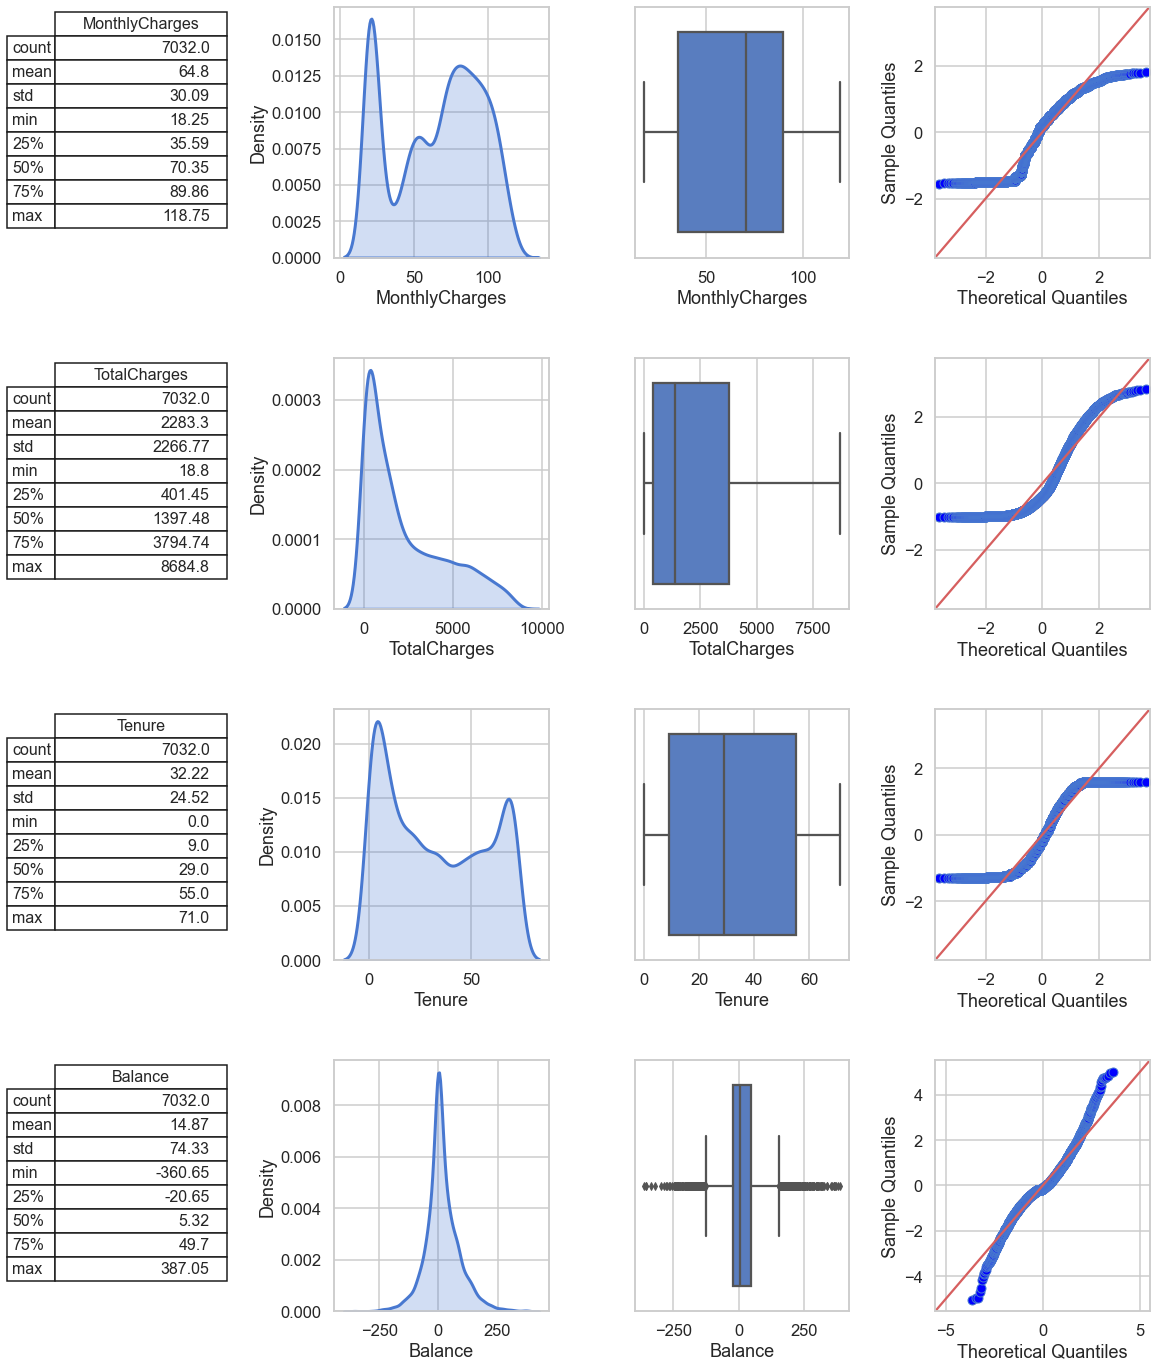

In [17]:
num_cols = ['MonthlyCharges', 'TotalCharges', 'Tenure', 'Balance']
df_descr = round(df['contract'][num_cols].describe(), 2)

f, ax = plt.subplots(4, 4, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
f.set_figheight(24)
f.set_figwidth(20)

for i, col in enumerate(num_cols):
    ax_xy = [ax[i,0],ax[i,1],ax[i,2],ax[i,3]]

    the_table = ax_xy[0].table(
        #Содержимое таблицы в виде списка списков строк
        cellText = [list(x) for x in df_descr.loc[:,col].values.reshape(df_descr.shape[0],1).astype('str')],
        rowLabels = list(df_descr.index),
        colLabels = [col],
        loc = 'upper center',
        colWidths = [0.8]
    )
    the_table.scale(1, 2)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(16)
    ax_xy[0].grid(False)
    ax_xy[0].axis('off')

    sns.kdeplot(
        x = col,
        data = df['contract'],
        shade = True,
        linewidth = 3,
        ax = ax_xy[1]
    )

    sns.boxplot(
        x = col,
        data = df['contract'],
        orient = 'h',
        ax = ax_xy[2]
    )
    sm.qqplot(df['contract'][col], line='45', fit=True, ax=ax_xy[3])

plt.show()

На графике с продолжительностью пользования услугами есть два пика: один близок к нулю, другой - больше 50-и. Это соответсвует двум сценариям поведения: клиент либо пробует и потом уходит, либо остаётся надолго.

В распределении TotalCharges наблюдается длинный правый хвост - это соответствует поведению клиентов. Те клиенты, которые уходят быстро, платят в сумме мало, но количество таких клиентов большое. Те клиенты, которые остаются надолго, заплатят больше - пропорционально продолжительности действия договора - и эти суммы растягиваются справа.

У большинства клинтов остаток средств близок к нулю и при этом положительный, но существуют выбросы справа и слева: клиенты, заплатившие вперёд, и клиенты с большим долгом.

В ежемесячных тратах есть два пика - возможно, это разница объясняется тем, что не у всех клиентов подключен интернет и не у всех есть телефон. Посмотрим, существуют ли клиенты, у которых ничего не подключено.

In [18]:
df['contract'].join(df['internet']).join(df['phone']).isna().sum(axis=1).value_counts()

0    4832
7    1520
1     680
dtype: int64

- Значение 0 - нет пропусков - все услуги подключены - таких клиентов большинство. 
- Пропущенно 7 значений - это соответствует семи столбцам таблицы internet - у этих пользователей не подключен интернет. Таких клиентов 1526 - достаточно много, видимо, именно на них приходится левый пик в ежемесячных тратах: без интернета они платят за услуги меньше остальных. 
- Пропущенно 1 - соответствует единственному столбцу таблицы phone - клиенты, у которых не подключен телефон.

В таблице нет клиентов, для которых бы не было информации об услугах.

Посмотрим, как влияют услуги на деньги.

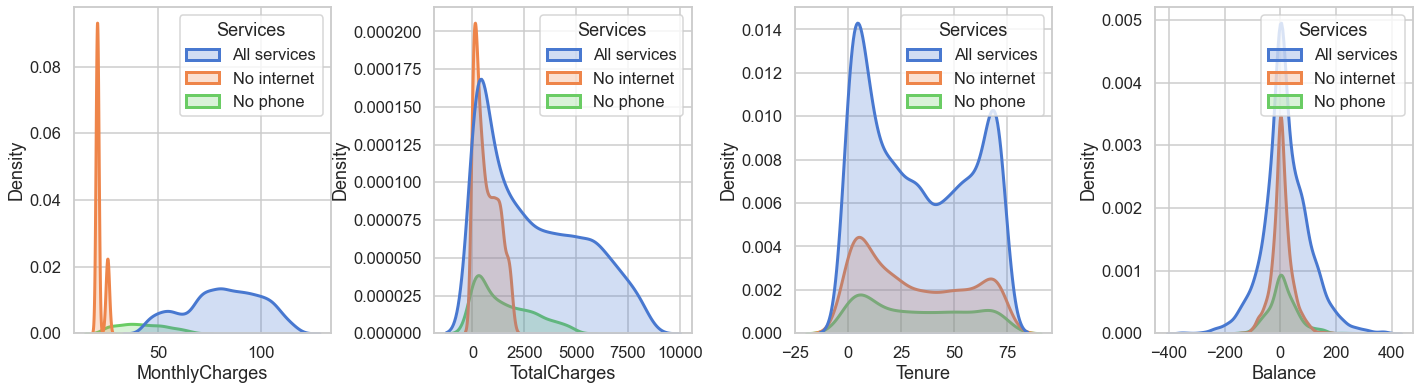

In [19]:
df['contract']['Services'] = (
    df['contract']
    .join(df['internet'])
    .join(df['phone'])
    .isna().sum(axis=1)
    .map({0: 'All services', 7: 'No internet', 1: 'No phone'})
    .astype('category')
)

def hue_plot(hue_col):
    '''
    Выводит частотные гистограммы для столбцов MonthlyCharges, TotalCharges, Tenure, Balance
    таблицы contract с параметром hue=hue_col.
    '''
    f, ax = plt.subplots(1, 4, gridspec_kw={'wspace': 0.4})
    f.set_figheight(6)
    f.set_figwidth(24)

    for i, col in enumerate(num_cols):
        sns.kdeplot(
            x = col,
            data = df['contract'],
            hue = hue_col,
            shade = True,
            linewidth = 3,
            ax = ax[i]
        )

    plt.show()
    
hue_plot('Services')

Действительно, клиенты без интернета платят меньше, именно на них приходится левый пик в ежемесячных тратах. Они же усиливуют левую часть графика TotalCharges. При этом сохраняется общий поведенческий паттерн: если клиент не уходит быстро, то задерживается надолго. Хотя для той части пользователей, которые пользуются только интернетом, левый пик выражен существенно меньше, они реже быстро уходят.

Посмотрим, влияют ли персональные данные на то, как долго клиенты пользуются услугами и сколько платят. 

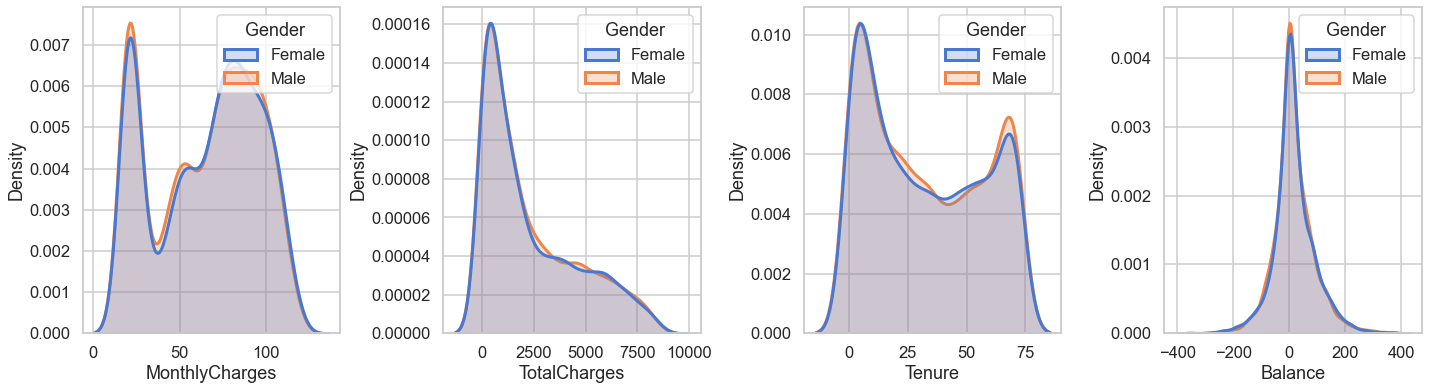

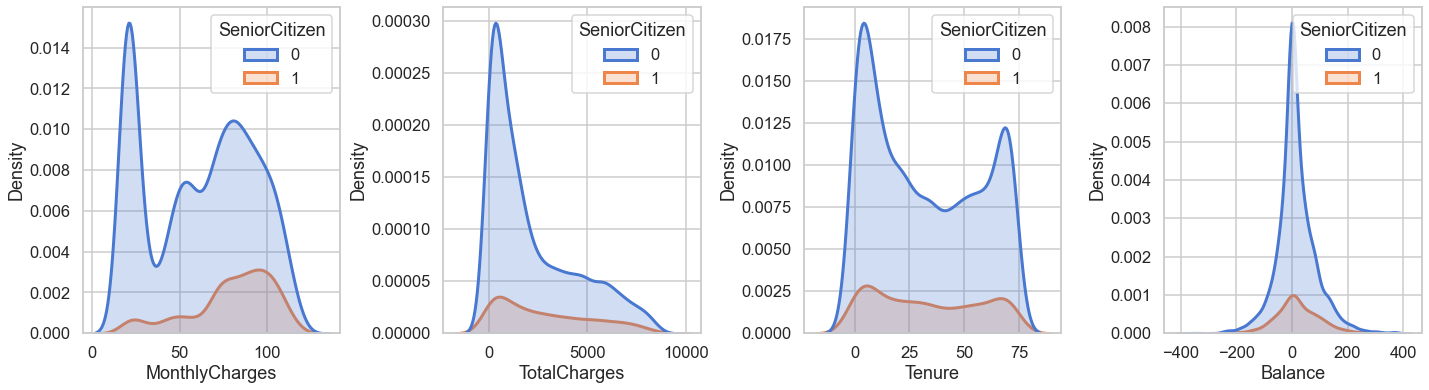

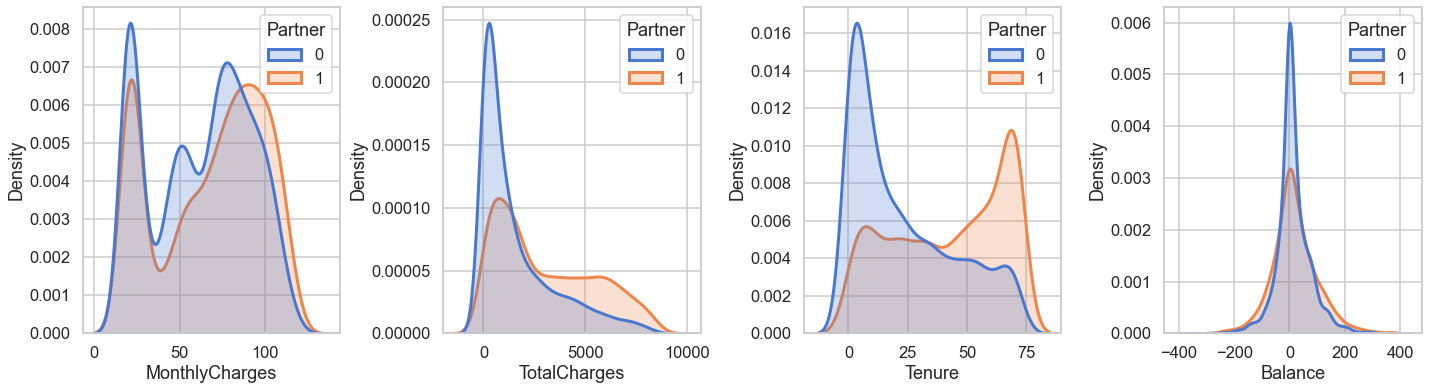

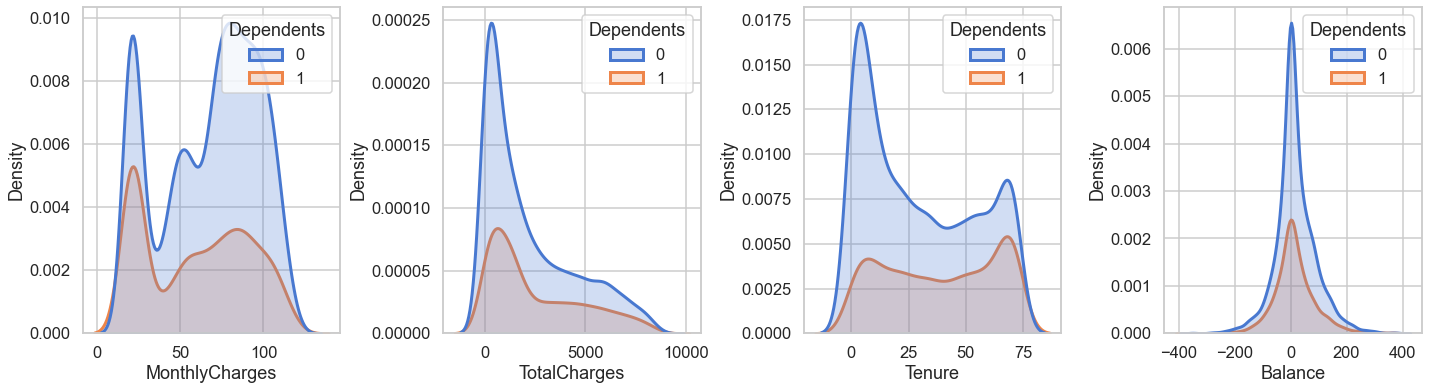

In [20]:
hue_cols = list(df['personal'].columns)

df['contract'] = df['contract'].join(df['personal'])

for hue_col in hue_cols:
    hue_plot(hue_col)

Видно, что клиенты, у которых есть партнёр, задерживаются дольше.

Также посмотрим на различая в тратах в зависимости о типа счёта и на разницу среди ушедших и оставшихся.

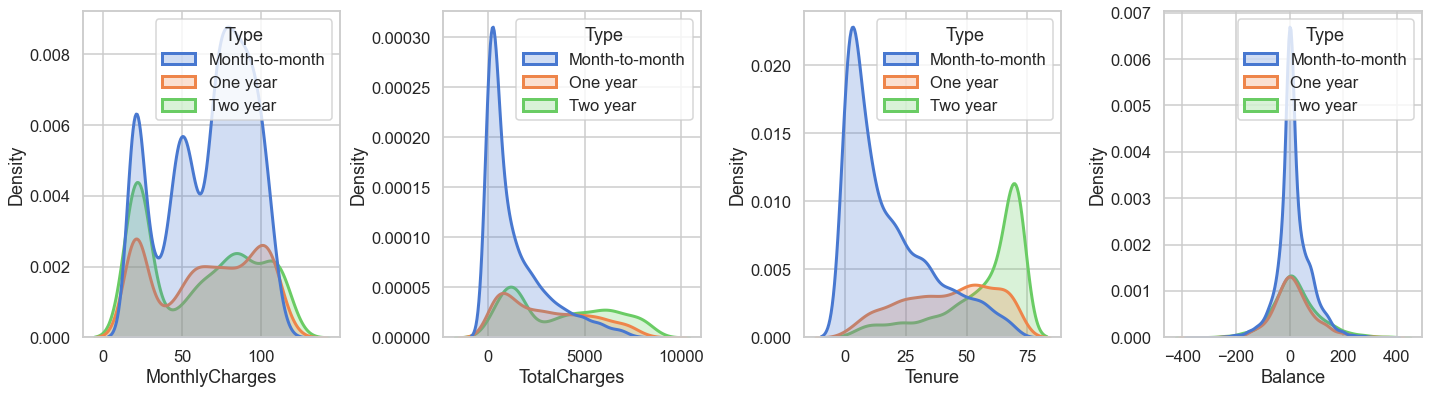

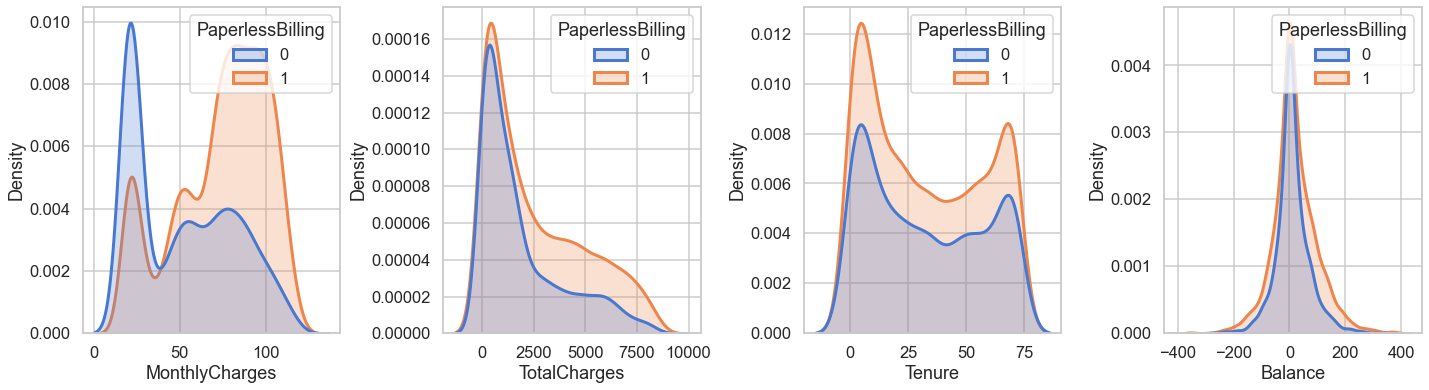

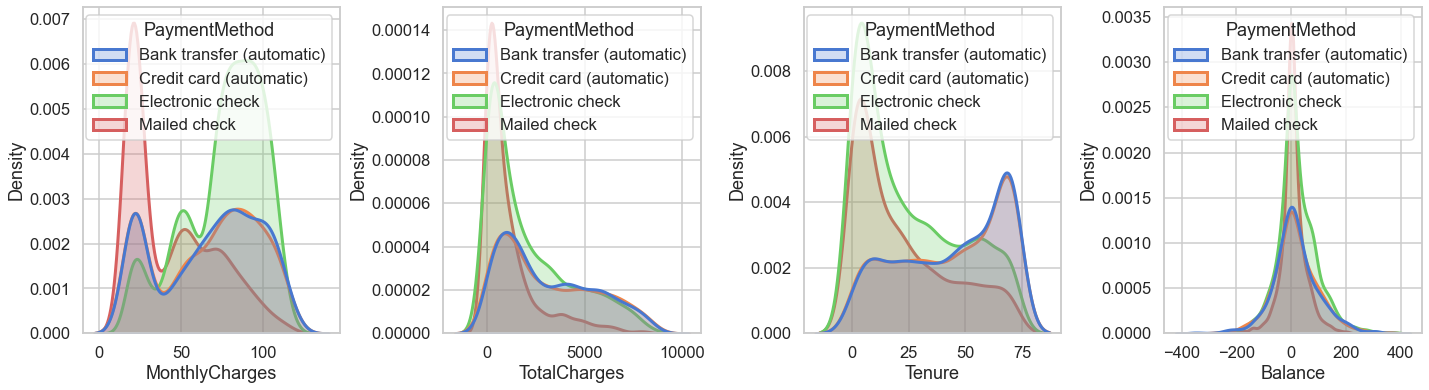

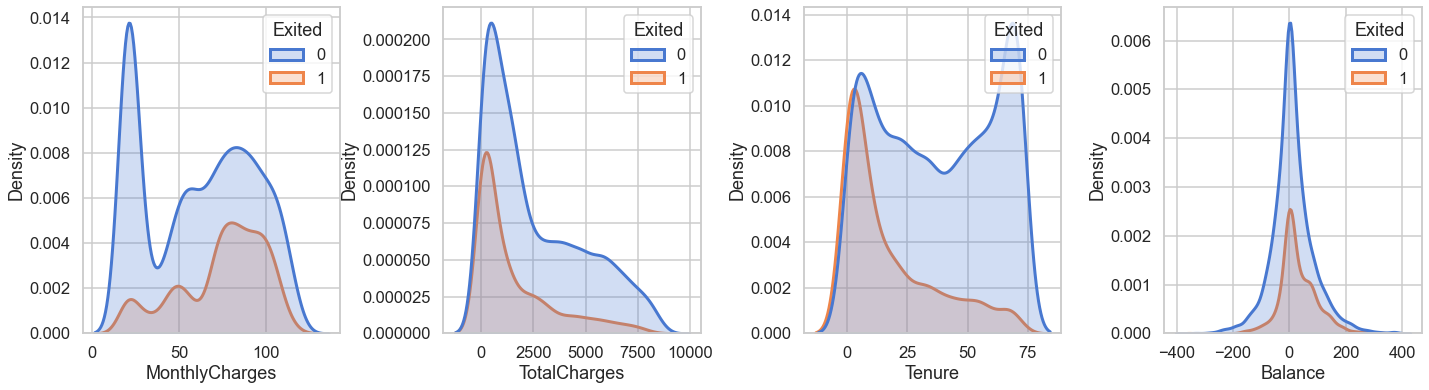

In [21]:
for hue_col in ['Type', 'PaperlessBilling', 'PaymentMethod', 'Exited']:
    hue_plot(hue_col)

На графиках можно заметить следующее:
- Клиенты, заключившие договор на два года, дольше остаются клиентами - это закономерно. 
- Те клиенты, которые отказались от бумажного счёта, платят в месяц больше - скорее всего это активные пользователи интернета.
- Пользователи, у которых настроен автоплатёж, также задерживаются дольше.
- Среди ушедших клиентов распределение времени пользования услугами другое: нет правого пика. Можно сказать, работает правило: ушёл сразу или остался надолго. Правый пик на всех графиках приходится на клиентов, которые по-прежнему остаются клиентами.

Добавим признак "подключен автоплатёж".

In [22]:
df['contract']['AutoPayment'] = ['automatic' in value for value in df['contract']['PaymentMethod'].values]
df['contract']['AutoPayment'] = df['contract']['AutoPayment'].astype('int')

Посмотрим, как влияют различные интернет-услуги на траты клиентов.

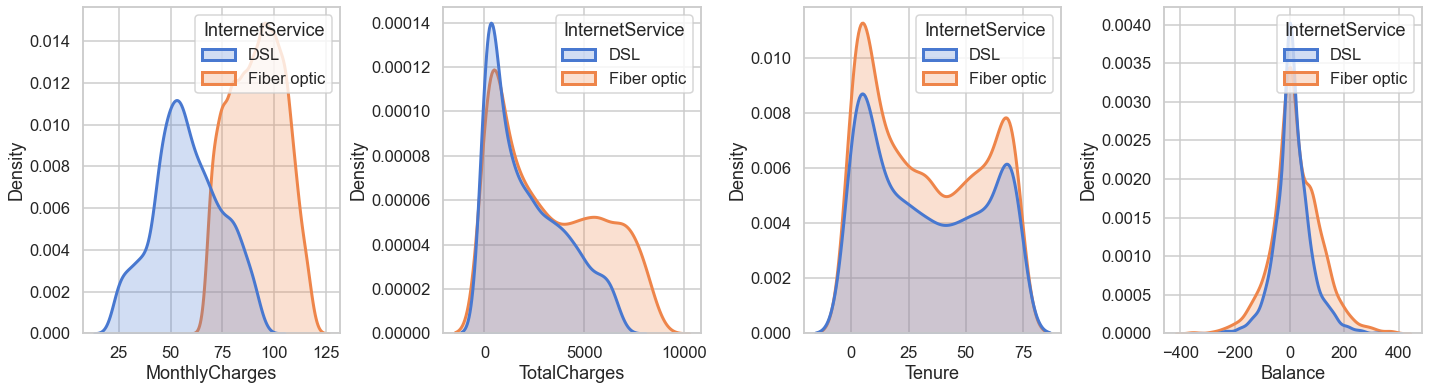

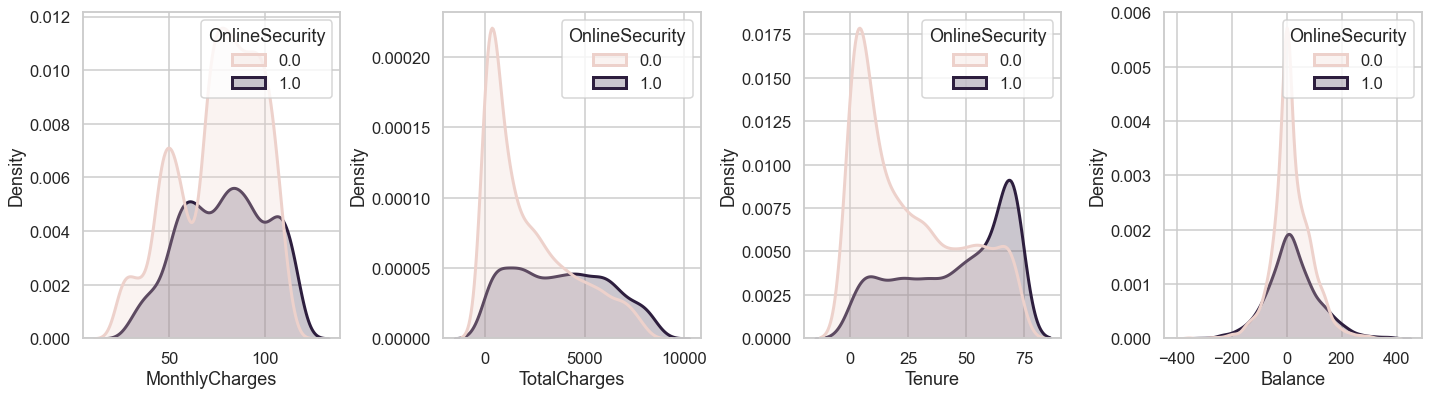

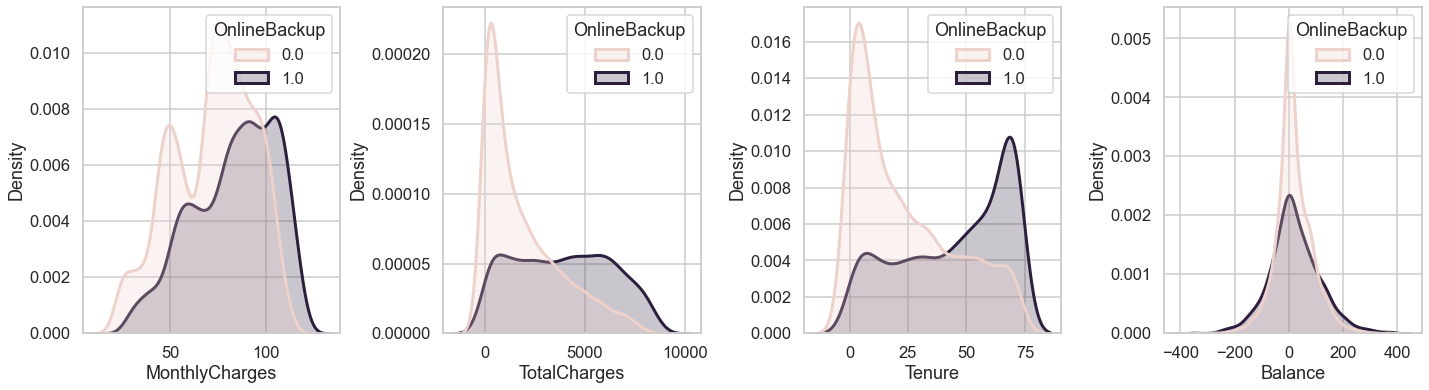

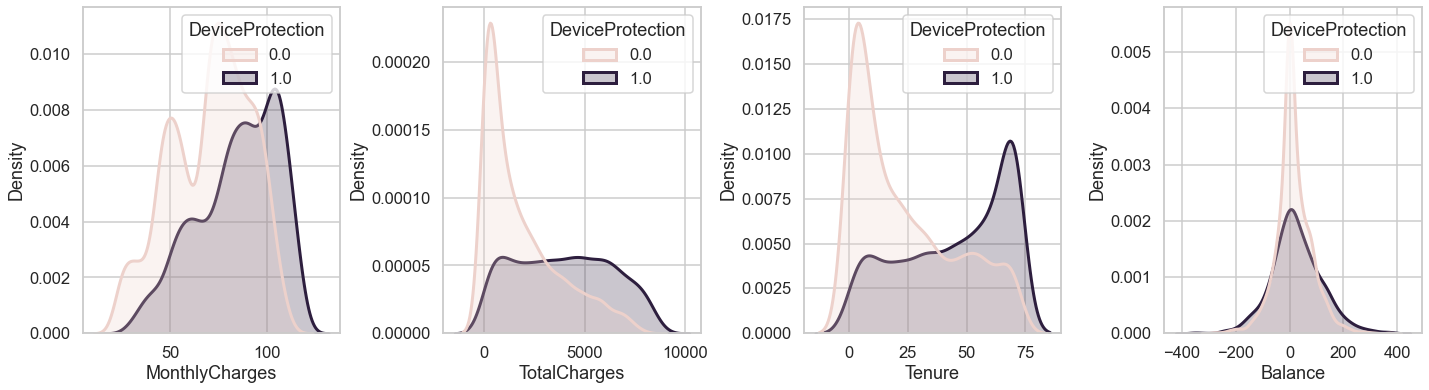

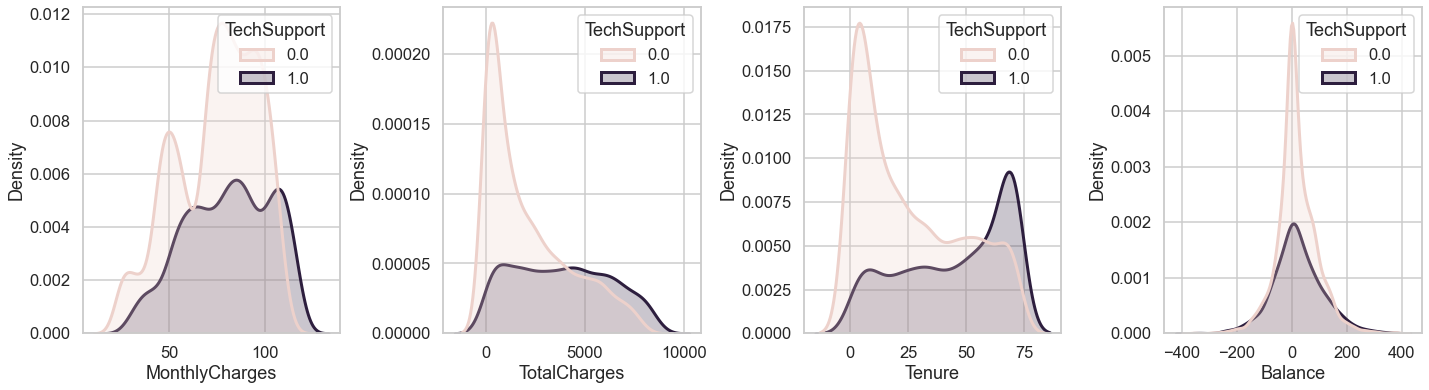

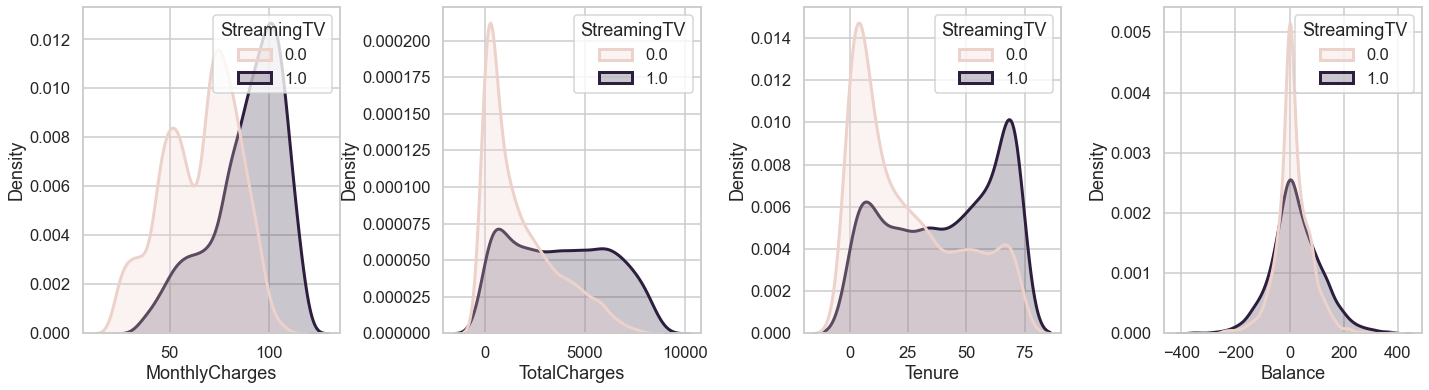

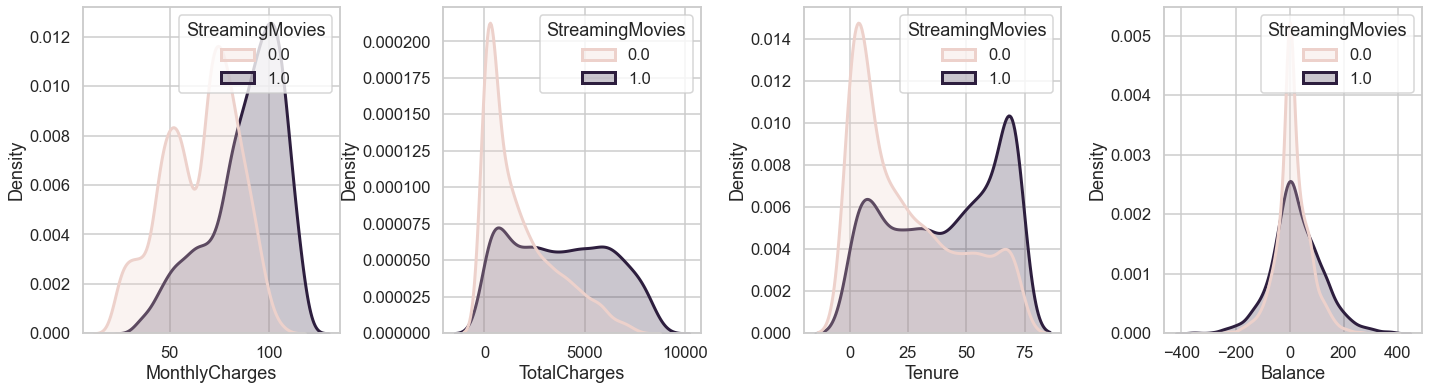

In [23]:
hue_cols = list(df['internet'].columns)

df['contract'] = df['contract'].join(df['internet'])

for hue_col in hue_cols:
    hue_plot(hue_col)

Оптика стоит дороже DSL, но на время действия договора это не влияет. Видно, что клиенты, использующие доп. услуги, дольше остаются клиентами. 

Заполним пропуски значением "No internet".

In [24]:
df['contract']['InternetService'].cat.add_categories('No internet', inplace=True)
df['contract'][hue_cols] = df['contract'][hue_cols].fillna('No internet').astype('category')

Посмотрим, как влияет количество телефонных линий на траты.

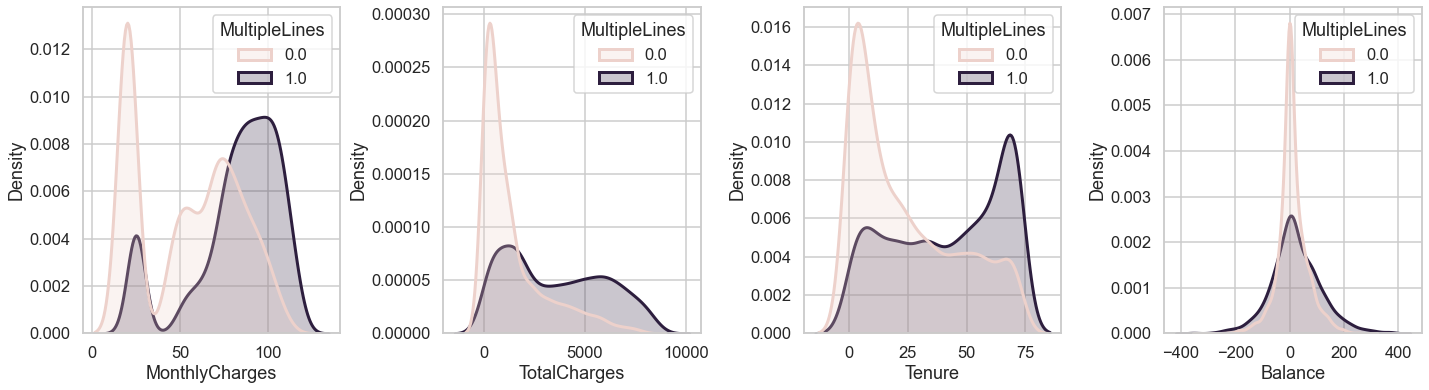

In [25]:
df['contract'] = df['contract'].join(df['phone'])

hue_plot(df['phone'].columns[0])

Клиенты с несколькими телефонными линиями задерживаются дольше, чем клиенты с одной телефонной линией. Одна линия дешевле, но для обоих вариантов существует два пика на диаграмме ежемесячных трат - это может быть связано с тем, что у части клиентов не подключен интернет.

Пропуски означают, что у клиента не подключена никакая телефонная линия. Переделаем столбец в категориальный со значениями "One line", "Multiple lines" и "No phone".

In [26]:
df['contract'] = df['contract'].rename(columns={'MultipleLines': 'Phone'})
df['contract']['Phone'] = (
    df['contract']['Phone'].fillna(-1)
    .map({0: 'One line', 1: 'Multiple lines', -1: 'No phone'})
    .astype('category')
)

Теперь в таблице contract собраны данные из всех таблиц. 

Если возможно, уменьшим размерность для числовых типов данных.

In [27]:
df = df['contract']

int_cols = [col for col in df.columns if df[col].dtype == 'int64']
float_cols = [col for col in df.columns if df[col].dtype == 'float64']

for col in int_cols:
    df[col] = pd.to_numeric(df[col], downcast='integer')

for col in float_cols:
    df[col] = pd.to_numeric(df[col], downcast='float')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   datetime64[ns]
 2   Type              7032 non-null   category      
 3   PaperlessBilling  7032 non-null   int8          
 4   PaymentMethod     7032 non-null   category      
 5   MonthlyCharges    7032 non-null   float32       
 6   TotalCharges      7032 non-null   float32       
 7   Exited            7032 non-null   int8          
 8   Tenure            7032 non-null   int8          
 9   Balance           7032 non-null   float32       
 10  Services          7032 non-null   category      
 11  Gender            7032 non-null   category      
 12  SeniorCitizen     7032 non-null   int8          
 13  Partner           7032 non-null   int8          
 14  Dependents    

**Вывод**

В таблицах представлена информация о 7043 клиентах, из которых 26.5% ушли. У части клиентов не подключен стационарный телефон, у части - интернет, но большинство пользуется обеими услугами. 11 клиентов подключились в день выгрузки данных, поэтому информация о них не представляет ценности для решаемой задачи. Эти клиенты были удалены из рассмотрения.

Клиенты, использующие только телефон, платят в месяц меньше остальных, возможно, именно они в большинстве своём предпочитают получать бумажный счёт на оплату.

Среди всех клиентов дольше, как правило, остаются те, кто имеет партнёра, заключил договор на два года, настроил автоплатёж и пользуется дополнительными услугами.

Чем дольше клиент является клиентом, тем меньше вероятность, что он уйдёт.

Для оценки качества прогноза ухода клиента подойдёт метрика ROC-AUC, потому что важно знать не только точность прогноза, но и количество ложноположительных ответов.

## Изучение признаков

Целевым признаком является Exited - клиент ушёл. Все остальные признаки, кроме дат, можно использовать для обучения модели. Посмотрим на их взаимосвязи.

In [28]:
target_col = 'Exited'

cat_cols = [col for col in df.columns if is_categorical_dtype(df[col])]
num_cols = float_cols + ['Tenure']
bool_cols = int_cols
bool_cols.remove(target_col)
bool_cols.remove('Tenure')

features_cols = cat_cols + num_cols + bool_cols

In [29]:
round(df[num_cols].corr(), 2)

MonthlyCharges  TotalCharges  Balance  Tenure
MonthlyCharges            1.00          0.65     0.13    0.25
TotalCharges              0.65          1.00     0.15    0.82
Balance                   0.13          0.15     1.00    0.06
Tenure                    0.25          0.82     0.06    1.00

Оплата за всё время сильно коррелирует с количеством месяцев действия договора и заметно связано с суммой за месяц. Посмотрим на график.

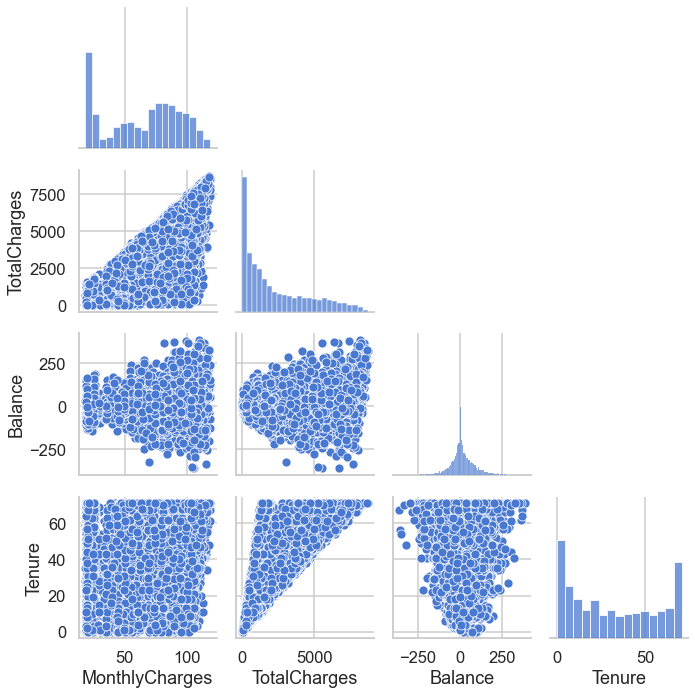

In [30]:
sns.pairplot(data=df, x_vars=num_cols, y_vars=num_cols, corner=True)
plt.tight_layout()
plt.show()

Чем больше стоимость месяца и дольше действует договор, тем больше будет значение TotalCharges. При обучении можно исключить этот признак.

Посмотрим на взаимосвязь категориальных признаков с помощью критерия V Крамера.

In [31]:
def cramers_v(contingency_table):
    '''
    Статистика V Крамера для расчета корреляции категориальных переменных.
    '''
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [32]:
cat_corrs = pd.DataFrame(index=cat_cols+bool_cols, columns=cat_cols+bool_cols, data=1)

for i, col_0 in enumerate((cat_cols+bool_cols)[:-1]):
    for col_1 in (cat_cols+bool_cols)[i+1:]:
        corr = cramers_v(pd.crosstab(df[col_0], df[col_1]).values)
        cat_corrs.loc[col_0,col_1] = corr
        cat_corrs.loc[col_1,col_0] = corr
        
cat_corrs = round(cat_corrs, 2)

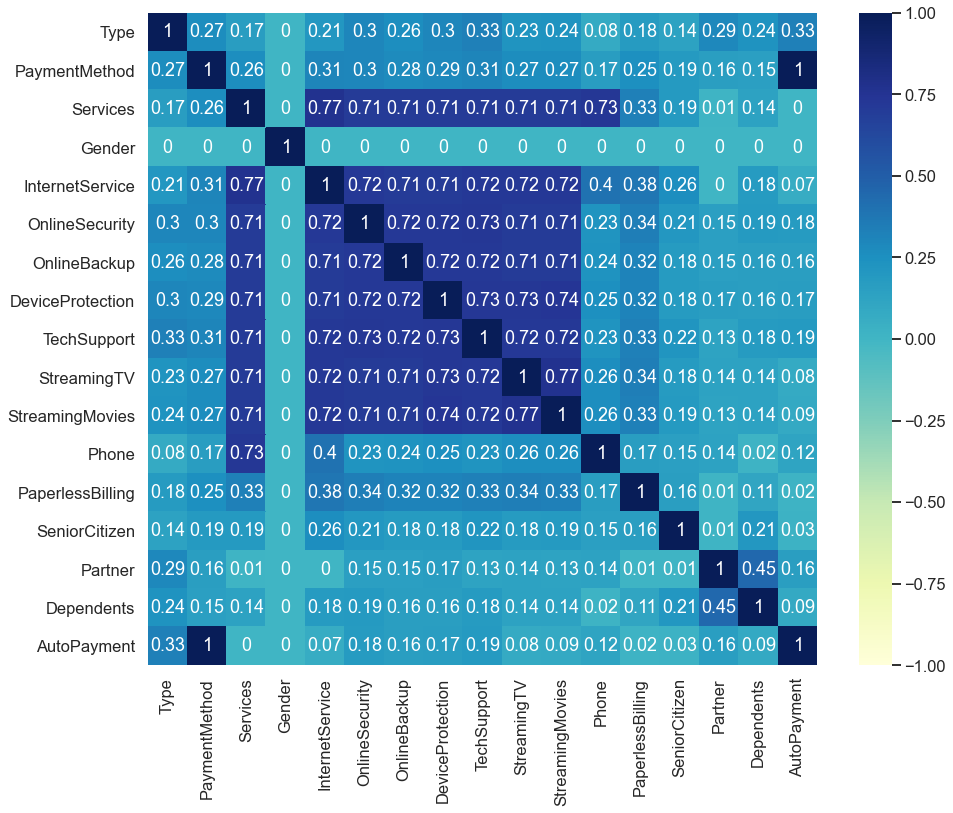

In [33]:
f, ax = plt.subplots(figsize=(15, 12))
ax = sns.heatmap(cat_corrs, center=0, vmax=1, vmin=-1, annot=True, cmap='YlGnBu')
plt.show()

AutoPayment и PaymentMethod коррелируют между собой, что объяснимо: одно создано из другого. При этом AutoPayment меньше коррелирует со всеми остальными категориальными признаками по сравнению с PaymentMethod, за исключением признака Type - этот признак больше связан с AutoPayment, чем с PaymentMethod. Для модели нужно оставить один из этих двух признаков.

Services сильно коррелирует с InternetService, Phone и дополнительными интернет-услугами, потому что отражает в себе наличие или отуствие той или иной услуги у клиента. Аналогично InternetService и доп. услуги связаны между собой: если у клиента нет интернета, то и дополнительных интернет-услуг точно нет. Возможно, созданный признак Services нужно будет удалить. Посмотрим на взаимосвязь этих признаков.

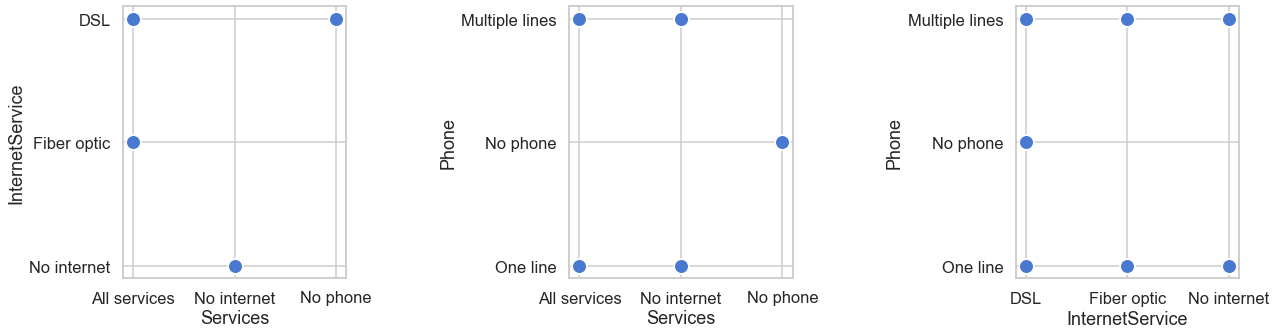

In [34]:
service_cols = ['Services', 'InternetService', 'Phone']

f, ax = plt.subplots(1, 3, gridspec_kw={'hspace': 0.4, 'wspace': 1})
f.set_figheight(5)
f.set_figwidth(20)
i = 0
for j, col_0 in enumerate(service_cols[:-1]):
    for col_1 in service_cols[j+1:]:
        sns.scatterplot(x=col_0, y=col_1, data=df, s=200, ax=ax[i])
        i += 1

plt.show()

Можно заметить интересную закономерность: у пользователей, у которых не подключен телефон, интернет всегда DSL. Также видно, что признак 'Services' избыточен.

Признак Gender не коррелирует с другими признаками. Возможно, с целевым признаком он также не коррелирует. Посмотрим на взаимную информацию между признаками и целевым признаком. Для этого временно создадим X и y, закодируем категориальные признаки и масштабируем числовые. 

In [35]:
X = df[features_cols].copy()
y = df[target_col].copy()

encoder = OrdinalEncoder()
X[cat_cols] = encoder.fit_transform(X[cat_cols].astype('str'))
X[cat_cols] = X[cat_cols].astype('int8')

num_transformer = QuantileTransformer(random_state=RS)
X[num_cols] = num_transformer.fit_transform(X[num_cols])

In [36]:
def mutual_info(X, y, cols=None):
    '''
    Возвращает взаимную информацию между признаками и целевым признаком.
    По умолчанию работает для всех столбцов.
    '''
    if cols == None:
        cols = X.columns
        
    return pd.DataFrame({
        'feature': cols,
        'value': mutual_info_classif(X[cols], y, random_state=RS)
    }).sort_values(by='value', ascending=False).set_index('feature')

In [37]:
mutual_info(X, y)

value
feature                   
Tenure            0.114681
Type              0.099476
OnlineSecurity    0.064683
TechSupport       0.063713
OnlineBackup      0.053029
InternetService   0.051875
PaymentMethod     0.045992
MonthlyCharges    0.045618
DeviceProtection  0.045128
TotalCharges      0.044838
StreamingTV       0.035075
Services          0.030309
AutoPayment       0.026024
Balance           0.025479
StreamingMovies   0.025403
PaperlessBilling  0.022547
Phone             0.014173
SeniorCitizen     0.011279
Partner           0.008282
Dependents        0.007470
Gender            0.001685

Больше всего на целевой признак влияют способ оплаты и количество месяцев действия договора.

Признак Gender имеет близкую к нулю объясняющую способность, его можно удалить.

Объясняющая способность MonthlyCharges превосходит TotalCharges, кроме того, с важным признаком Tenure меньше коррелирует MonthlyCharges. TotalCharges удалим из рассмотрения.

Признак PaymentMethod оказался лучше AutoPayment. AutoPayment удалим.

Признаки Services поднялся выше признака Phone. Возможно, его тянет вверх высокая корреляция с InternetService. У признака Phone посчитана нулевая объясняющая способность, но при взаимодействии с другими признаками он может давать ценную информацию.

Попробуем удалить признаки Gender, TotalCharges, AutoPayment, Services и посмотрим ещё раз на объясняющую способность оставшихся признаков. 

In [38]:
important_cols = list(set(features_cols) - \
                      set(['Gender', 'TotalCharges', 'AutoPayment', 'Services']))
mutual_info(X, y, cols=important_cols)

value
feature                   
Tenure            0.112062
Type              0.095070
TechSupport       0.068012
OnlineSecurity    0.057123
InternetService   0.055263
MonthlyCharges    0.051215
PaymentMethod     0.047608
OnlineBackup      0.047107
DeviceProtection  0.041704
StreamingMovies   0.035170
StreamingTV       0.031590
Balance           0.026377
PaperlessBilling  0.023583
Dependents        0.021407
Partner           0.009747
SeniorCitizen     0.008277
Phone             0.000478

Объясняющая способность признака Phone без Services остаётся низкой и даже уменьшилась. Модели может быть проще ориентироваться на информацию из Services. Можно удалить признаки Gender, TotalCharges и AutoPayment.

Также попробуем разделить пользователей на кластеры. Это кажется логичным: есть разные группы пользователей, которые отличаются профилем потребления - с телефоном и без, с разными типами интернета.

In [39]:
def cluster_info(df, cols, add_clusters=False, n_clusters=8):
    '''
    Разбивает на кластеры с помощью KMeans. 
    Показывает результат кластеризации на графике.
    Если add_clusters=True, добавляет результат кластеризации к датасету.
    ''' 
    df = df.copy()
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=RS)
    df['Сluster'] = kmeans.fit_predict(df[cols])
    
    tsne = TSNE(learning_rate=100, n_jobs=-1, random_state=RS)
    tsne_result = tsne.fit_transform(df[cols])
    x_axis_tsne = tsne_result[:, 0]
    y_axis_tsne = tsne_result[:, 1]
    
    f, ax = plt.subplots(1)
    f.set_figheight(9)
    f.set_figwidth(9)
    
    sns.scatterplot(x=x_axis_tsne, y=y_axis_tsne, hue=df['Сluster'], ax=ax)
    plt.show()
    
    if add_clusters:
        df['Сluster'] = df['Сluster'].astype('int8')
        return df

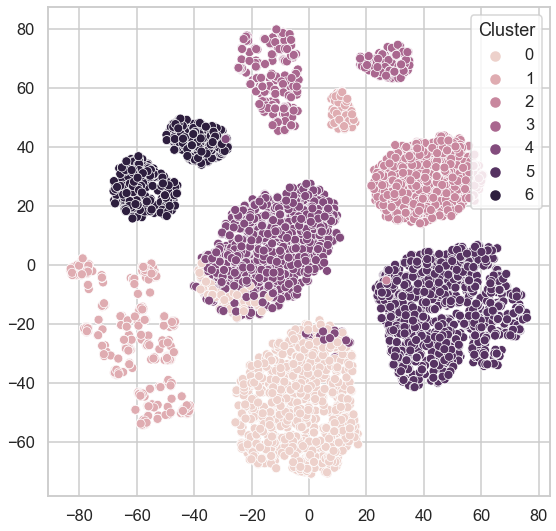

In [40]:
X = cluster_info(X, cols=features_cols, add_clusters=True, n_clusters=7)

Кроме того, попробуем использовать метод главных компонент для преобразования числовых признаков.

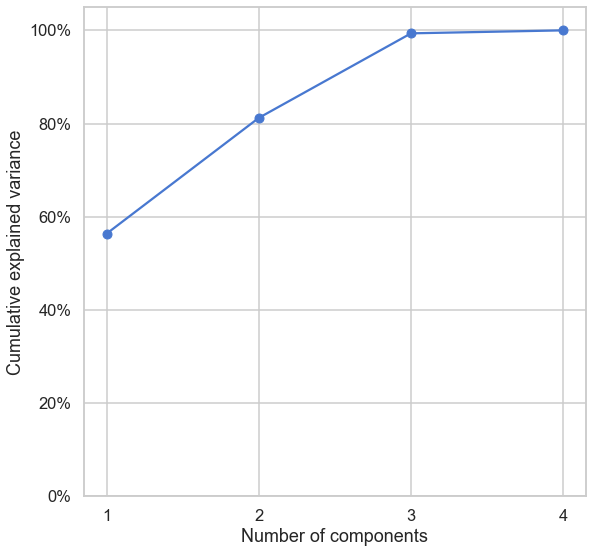

In [41]:
pca = PCA(random_state=RS)
X = X.join(pd.DataFrame(
    pca.fit_transform(X[num_cols]),
    index = X.index,
    columns = ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']
))


f, ax = plt.subplots(1)
f.set_figheight(9)
f.set_figwidth(9)

pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)).plot(ax=ax, style='o-', ylim=(0, 1.05), legend=False)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
ax.set_xticklabels([int(x+1) for x in ticks_loc])

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
ax.set_yticklabels(['{:.0%}'.format(x) for x in ticks_loc])

plt.show()

Трёх компонент будет достаточно. Посмотрим на объясняющую способность признаков.

In [42]:
mutual_info(X, y)

value
feature                   
Tenure            0.110933
Type              0.088652
PCA_2             0.074596
TechSupport       0.071233
OnlineSecurity    0.061137
Сluster           0.059526
InternetService   0.056685
PCA_1             0.052922
OnlineBackup      0.048541
MonthlyCharges    0.047784
DeviceProtection  0.045347
TotalCharges      0.045281
PaymentMethod     0.044906
StreamingMovies   0.029324
Services          0.028513
PCA_0             0.027164
Balance           0.025259
AutoPayment       0.025049
PCA_3             0.024828
StreamingTV       0.024537
PaperlessBilling  0.023936
Dependents        0.019564
SeniorCitizen     0.014774
Partner           0.000491
Phone             0.000000
Gender            0.000000

У новых созданных признаков хорошая объясняющая способность, при этом PCA_3 можно не использовать.

**Вывод**

Создан список признаков, отдельно выделен целевой признак. Проанализированы корреляции признаков и их объясняющая способность. Рассмотрена возможность использования кластеризации и метода главных компонент для создания новых признаков.

Признаки Gender, TotalCharges и AutoPayment можно не использовать при обучении модели. Gender имеет нулевую объясняющую способность, TotalCharges сильно коррелирует с информацией о количестве месяцев и стоимости в месяц, а AutoPayment выделен из PaymentMethod, но меньше влияет на целевую переменную.

Кластеризация и метод главных компонент показали хорошие результаты.

## Подготовка к обучению

Gender ни на что не влияет - сразу удалим его из списка признаков.

In [43]:
cat_cols.remove('Gender')
features_cols.remove('Gender')

drop_cols = ['TotalCharges', 'AutoPayment']

Разделим данные на тестовую и обучающую выборки. Для теста выделим 20%, на оставшихся 80% будем проводить кросс-валидацию в соотношении 1:3, чтобы размер валидационной выборки был равен размеру тестовой.

In [44]:
X, X_test, y, y_test = train_test_split(
    df[features_cols], df[target_col], test_size=0.2, random_state=RS, stratify=df[target_col])

На каждом шаге кросс валидации необходимо:

1. Отмасштабировать числовые признаки и закодировать категориальные.
2. Создать новые признаки.

При этом fit_transform возможен на обучающей части, а на валидационной - только transform. Напишем класс для использования его в пайплайне с моделью.

Для моделей на основе деревьев подойдёт порядковое кодирование, которое было использована при анализе. Для логистической регрессии нужно будет предусмотреть возможность использовать прямое кодирование.

In [45]:
class FeaturesTransformer():
    def __init__(self, ohe=False, cat_cols=cat_cols, 
                 num_cols=num_cols, bool_cols=bool_cols, 
                 features_cols=features_cols, drop_cols=drop_cols):
        self.ohe = ohe
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.bool_cols = bool_cols
        self.features_cols = features_cols
        self.drop_cols = drop_cols
        
    def fit_transform(self, X, y=None):
        X = X.copy()
        
        self.encoder = OrdinalEncoder()
        X[self.cat_cols] = self.encoder.fit_transform(X[self.cat_cols].astype('str'))
        
        self.num_transformer = QuantileTransformer(random_state=RS)
        X[self.num_cols] = self.num_transformer.fit_transform(X[self.num_cols])
        
        self.kmeans = KMeans(n_clusters=7, n_init=50, random_state=RS)
        X['Сluster'] = self.kmeans.fit_predict(X[self.features_cols])
        
        X[self.cat_cols + ['Сluster']] = X[self.cat_cols + ['Сluster']].astype('int8')
        
        self.pca = PCA(n_components=3, random_state=RS)
        X = X.join(pd.DataFrame(
            self.pca.fit_transform(X[self.num_cols]),
            index = X.index,
            columns = ['PCA_0', 'PCA_1', 'PCA_2']
        ))
        
        X[self.num_cols + ['PCA_0', 'PCA_1', 'PCA_2']] = (
            X[self.num_cols + ['PCA_0', 'PCA_1', 'PCA_2']].astype('float32')
        )
        
        if self.ohe:
            self.ohe_encoder = OneHotEncoder(drop='first', sparse=False)
            X = (
                X[self.num_cols + self.bool_cols + ['PCA_0', 'PCA_1', 'PCA_2']]
                .join(pd.DataFrame(
                    self.ohe_encoder.fit_transform(X[self.cat_cols + ['Сluster']]),
                    index = X.index,
                    columns = self.ohe_encoder.get_feature_names(self.cat_cols + ['Сluster'])
                ))
            )
            
        X = X.drop(self.drop_cols, axis=1)
        
        self.cols = X.columns
        return X
    
    def transform(self, X, y=None):
        X = X.copy()
        
        X[self.cat_cols] = self.encoder.transform(X[self.cat_cols].astype('str'))
        X[self.num_cols] = self.num_transformer.transform(X[self.num_cols])
        X['Сluster'] = self.kmeans.predict(X[self.features_cols])
        X[self.cat_cols + ['Сluster']] = X[self.cat_cols + ['Сluster']].astype('int8')
        
        X = X.join(pd.DataFrame(
            self.pca.transform(X[self.num_cols]),
            index = X.index,
            columns = ['PCA_0', 'PCA_1', 'PCA_2']
        ))
        
        X[self.num_cols + ['PCA_0', 'PCA_1', 'PCA_2']] = (
            X[self.num_cols + ['PCA_0', 'PCA_1', 'PCA_2']].astype('float32')
        )
        
        if self.ohe:
            X = (
                X[self.num_cols + self.bool_cols + ['PCA_0', 'PCA_1', 'PCA_2']]
                .join(pd.DataFrame(
                    self.ohe_encoder.transform(X[self.cat_cols + ['Сluster']]),
                    index = X.index,
                    columns = self.ohe_encoder.get_feature_names(self.cat_cols + ['Сluster'])
                ))
            )
            
        X = X.drop(self.drop_cols, axis=1)
        return X

Создадим функцию, которая для модели вернёт пайплайн: предобработка + модель.

In [46]:
def get_pipline(model, ohe=False, cat_cols=cat_cols, 
                num_cols=num_cols, bool_cols=bool_cols, 
                features_cols=features_cols, drop_cols=drop_cols):
    '''
    Создаёт пайплайн: преобразование признаков и модель. 
    '''
    pipeline = Pipeline(steps=[('preprocessor', FeaturesTransformer(ohe=ohe,
                                                                    cat_cols=cat_cols, 
                                                                    num_cols=num_cols,
                                                                    bool_cols=bool_cols, 
                                                                    features_cols=features_cols, 
                                                                    drop_cols=drop_cols)),
                               ('model', model)])

        
    return pipeline

**Вывод**

Данные разделены на обучающую и тестовую выборки. Если при кросс-валидации делить обучающую выборку на 4 части, отношение обучающей выборки к валидационной и к тестовой будет 3:1:1.

Создан класс для преобразования признаков: масштабирования числовых, кодирования категориальных, создания дополнительных признаков с помощью k-means и PCA, удаления ненужных признаков. Предусмотрена возможность использования OHE для категориальных признаков.

Написана фунция для создания пайплайна для заданной модели.

## Обучение моделей

Рассмотрим несколько моделей и для каждой подберём оптимальные гиперпараметры. Для ориентира посчитаем также метрику на dummy-модели. 

Если вариантов гиперпараметров немного, используем GridSearchCV и посмотрим их все. Если количество комбинаций существенно, воспользуемся RandomizedSearchCV.

Т.к. в данных есть дисбаланс классов, используем class_weight в моделях и помимо итогового значения метрики на кросс-валидации выведем получившееся оптимальное значение этого гиперпараметра.

In [47]:
%%time

models = [
    ('DummyClassifier', DummyClassifier(random_state=RS)),
    ('LogisticRegression', LogisticRegression(solver='liblinear', random_state=RS)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=RS)),
    ('LGBMClassifier', LGBMClassifier(random_state=RS))
]

params = {
    'DummyClassifier': {
        'model__strategy': ['stratified', 'most_frequent', 'prior', 'uniform']
    },
    'LogisticRegression': {
        'model__penalty': ['l1','l2'],
        'model__C': [0.1, 0.5, 10, 20, 50, 70, 100],
        'model__class_weight': ['balanced', None]
    },
    'RandomForestClassifier': {
        'model__n_estimators': range(100, 500, 50),
        'model__max_depth': range(6, 21, 2),
        'model__criterion': ['gini', 'entropy'],
        'model__min_samples_leaf': range(10, 51, 10),
        'model__class_weight': ['balanced', 'balanced_subsample', None]
    },
    'LGBMClassifier': {
        'model__n_estimators': range(300, 1001, 100),
        'model__max_depth': range(2, 11),
        'model__num_leaves': [10, 20, 30, 50, 70, 100],
        'model__min_child_samples': range(10, 51, 10),
        'model__reg_alpha': [0, 0.3, 0.7, 1],
        'model__reg_lambda': [0, 0.3, 0.7, 1],
        'model__subsample': [0.7, 1],
        'model__colsample_bytree': [0.7, 1],
        'model__learning_rate': [0.001, 0.01, 0.1],
        'model__class_weight': ['balanced', None]
    }
}

score_info = []
sf = StratifiedKFold(n_splits=4, random_state=RS, shuffle=True)
best_models = {}

search_params = {
    'cv': sf,
    'n_jobs': -1,
    'scoring': 'roc_auc',
    'refit': True,
    'verbose': 3
}
    
for model_name, model in models:
    if model_name == 'LogisticRegression':
        pipeline = get_pipline(model, ohe=True)
    else:
        pipeline = get_pipline(model)

    if model_name == 'LogisticRegression' or model_name == 'DummyClassifier':
        best_models[model_name] = GridSearchCV(pipeline, params[model_name], **search_params)
    else:
        best_models[model_name] = RandomizedSearchCV(pipeline, params[model_name],
                                                     n_iter=1000, random_state=RS, **search_params)
    
    best_models[model_name].fit(X, y)
    
    if model_name == 'DummyClassifier':
        score_info.append([model_name, best_models[model_name].best_score_, '-'])
    else:
        score_info.append([
            model_name, 
            best_models[model_name].best_score_, 
            best_models[model_name].best_params_['model__class_weight']
        ])

pd.DataFrame(data=score_info, columns=['model', 'ROC-AUC', 'class_weight']).set_index('model')

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 28 candidates, totalling 112 fits
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
CPU times: user 2min 6s, sys: 26.5 s, total: 2min 33s
Wall time: 19min 39s


ROC-AUC class_weight
model                                        
DummyClassifier         0.502639            -
LogisticRegression      0.854162         None
RandomForestClassifier  0.856617         None
LGBMClassifier          0.858997         None

Все модели существенно превзошли DummyClassifier, при этом показали близкие друг другу значения метрики. Лидирует LGBMClassifier. 

Ни одна из итоговых моделей не использует баланс классов. Попробуем различные техники борьбы с дисбалансом:
- увеличение выборки положительных объектов
- уменьшение выборки отрицательных объектов
- искусственное создание дополнительных объектов

Модель DummyClassifier была использована для обозначения порога адекватности и больше не нужна. Удалим её из best_models.

In [48]:
del best_models['DummyClassifier']

Напишем функции для увеличения и для уменьшения выборки.

In [49]:
def upsample(X, y, repeat):
    '''
    Повторяет выборку положительных объяктов repeat раз.
    '''
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=RS)
    return X_upsampled, y_upsampled

In [50]:
def downsample(X, y, fraction):
    '''
    Уменьшает выборку отрицательных объектов.
    fraction - доля положительных объектов, которую нужно оставить.
    '''
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat([X_zeros.sample(frac=fraction, random_state=RS)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=RS)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=RS)
    
    return X_downsampled, y_downsampled

Изменение размеров выборки невозможно встроить в стандартный пайплайн, поэтому сделаем кросс-валидацию вручную:
1. Разделим обучающую выборку на 4 части.
2. На каждом шаге выделим 1/4 данных в качестве валидационной выборки.
3. Для каждой модели сделаем следующее:
    - используем FeaturesTransformer
    - увеличим количество положительных объектов в 2 и в 3 раза
    - уменьшим количество отрицательных объектов: 0.4, 0.5 и 0.6 от изначального количества
    - увеличим количество положительных объектов, создав дополнительные с помощью модели
    
Для каждого эксперимента будем считать метрику. Итоговое значение метрики - среднее среди 4х метрик, посчитанных на разных валидационных выборках.

In [51]:
y_probs = {
    'LogisticRegression': [],
    'RandomForestClassifier': [],
    'LGBMClassifier': []
}

result_table = pd.DataFrame(
    index = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'],
    columns = ['upsample_2', 'upsample_3', 'downsample_0.4', 'downsample_0.5', 'downsample_0.6', 'SMOTE'],
    data = 0
)

for train_index, valid_index in sf.split(X, y):
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index, :]
    y_valid = y.iloc[valid_index]

    for model_name in best_models:
        model = best_models[model_name].best_estimator_['model']
        transformer = best_models[model_name].best_estimator_['preprocessor']

        X_train_trans = transformer.fit_transform(X_train)
        X_valid_trans = transformer.transform(X_valid)
        
        for repeat in [2, 3]:
            method_name = 'upsample_' + str(repeat)
            X_upsampled, y_upsampled = upsample(X_train_trans, y_train, repeat)
            model.fit(X_upsampled, y_upsampled)
            result_table.loc[model_name, method_name] += roc_auc_score(
                y_valid, model.predict_proba(X_valid_trans)[:,1]) / 4
            
        for fraction in np.arange(0.4, 0.7, 0.1):
            method_name = 'downsample_' + str(fraction)
            X_downsampled, y_downsampled = downsample(X_train_trans, y_train, fraction)
            model.fit(X_downsampled, y_downsampled)
            result_table.loc[model_name, method_name] += roc_auc_score(
                y_valid, model.predict_proba(X_valid_trans)[:,1]) / 4
            
        X_smote, y_smote = SMOTE(random_state=RS).fit_resample(X_train_trans, y_train)
        model.fit(X_smote, y_smote)
        result_table.loc[model_name, 'SMOTE'] += roc_auc_score(
            y_valid, model.predict_proba(X_valid_trans)[:,1]) / 4

result_table.join(
    pd.DataFrame(data=score_info, columns=['model', 'base score', '']).set_index('model')['base score'])

upsample_2  upsample_3  downsample_0.4  \
LogisticRegression        0.854013    0.853791        0.852750   
RandomForestClassifier    0.856370    0.855773        0.854212   
LGBMClassifier            0.857794    0.857643        0.855744   

                        downsample_0.5  downsample_0.6     SMOTE  base score  
LogisticRegression            0.853157        0.853317  0.850767    0.854162  
RandomForestClassifier        0.855219        0.855205  0.852398    0.856617  
LGBMClassifier                0.856470        0.857364  0.855155    0.858997

Манипулируя размером выборки, не удалось превзойти изначально посчитанные метрики.

Все три модели дают достаточно близкие значения ROC-AUC. Каждая из этих моделей могла найти одни закономерности в данных и пропустить другие. Посмотрим на важность признаков для этих моделей.

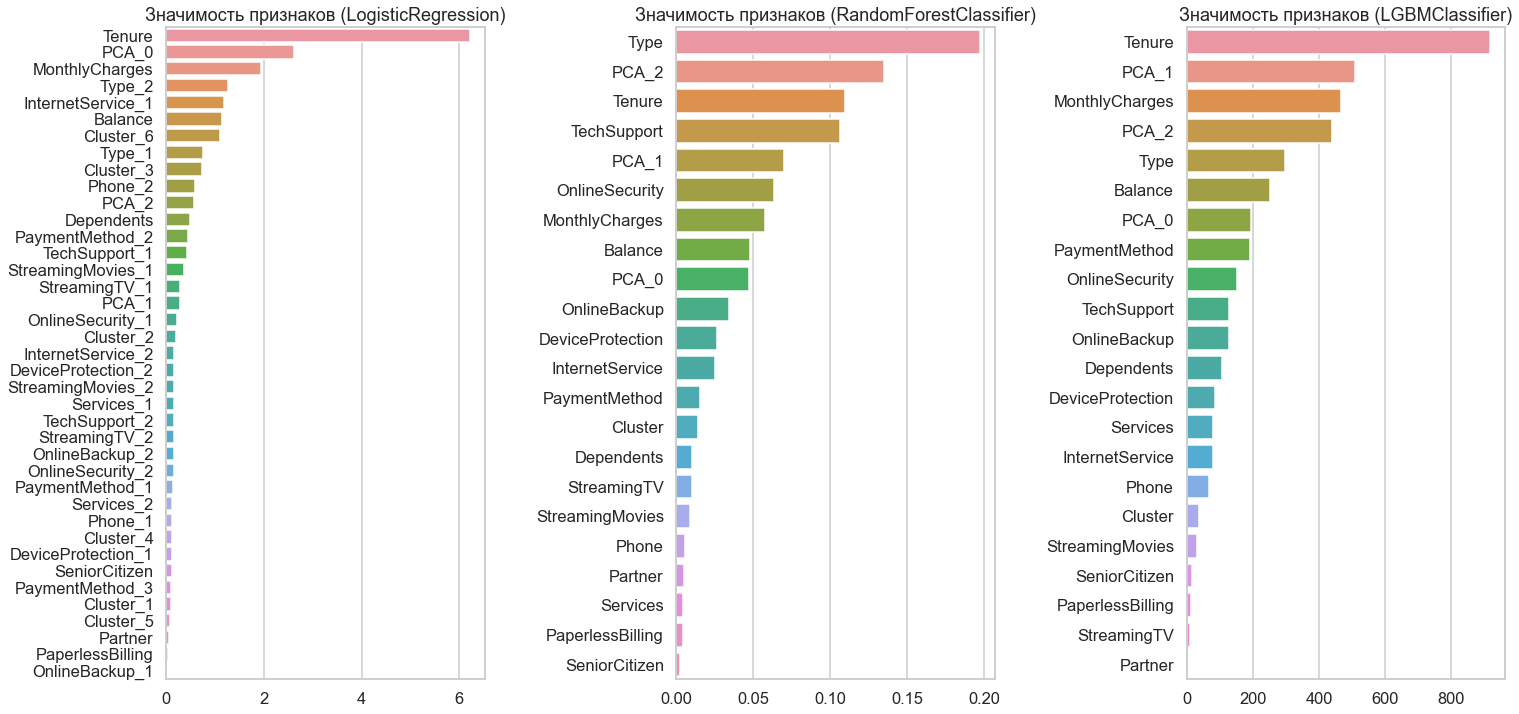

In [52]:
f, ax = plt.subplots(1, 3, gridspec_kw={'wspace': 0.6})
f.set_figheight(12)
f.set_figwidth(24)
i = 0

for model_name in best_models:
    if model_name == 'LogisticRegression':
        importance_values = np.abs(best_models[model_name].best_estimator_['model'].coef_.reshape(-1))
    else:
        importance_values = best_models[model_name].best_estimator_['model'].feature_importances_
        
    sns.barplot(
        data = (
            pd.DataFrame({
                'feature': best_models[model_name].best_estimator_['preprocessor'].cols, 
                'value': importance_values
            })
            .sort_values(by='value', ascending=False)
        ),
        x = 'value',
        y = 'feature',
        ax = ax[i]
    )
        
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('Значимость признаков (' + model_name + ')')
    i += 1

plt.show()

Действительно, разные модели ориентируются на разные признаки. При этом в лидерах тип договора (помесячная оплата или за 1-2 года), продолжительность действия договора и деньги в том или ином виде. Логистическая регрессия в отличие от других моделей больше опирается на интернет-сервис.

Используем работу всех трёх моделей для финального прогноза. Для этого соберём таблицу с предсказанными на кросс-валидации вероятностями и обучим RidgeClassifier, чтобы подобрать оптимальные коэффициенты к разным предсказаниям.

In [53]:
X_probas = pd.DataFrame(
    index=X.index, columns=['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'], data=0)

for train_index, valid_index in sf.split(X, y):
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index, :]

    for model_name in best_models:
        best_models[model_name].best_estimator_.fit(X_train, y_train)
        X_probas.loc[X_valid.index, model_name] = (
            best_models[model_name].best_estimator_.predict_proba(X_valid)[:,1]
        )

Переберём различные значения alpha для RidgeClassifier.

In [54]:
stack_model = GridSearchCV(
    RidgeClassifier(random_state=RS), 
    {'alpha': [0.3, 0.7, 1, 10, 20, 50, 70, 100]}, 
    **search_params
)

stack_model.fit(X_probas, y)
print('ROC-AUC = {}'.format(stack_model.best_score_))

Fitting 4 folds for each of 8 candidates, totalling 32 fits
ROC-AUC = 0.8604128085029017


Значение метрики улучшилось.

**Вывод**

Рассмотрены три модели: логистическая регрессия, случайный лес и градиентный бустинг. Все они превзошли dummy-модель на кросс-валидации. Для каждой модели подобраны оптимальные гиперпараметры. Лучшее значение ROC-AUC - у градиентного бустинга, при этом другие модели отстали незначительно.

Опробованы различные стратегии борьбы с дисбалансом: увеличение выборки положительных объектов, уменьшение выборки отрицательных объектов, искусственное создание положительных объектов с помощью модели. Ни одна из этих стратегий не помогла увеличить итоговую метрику.

Для улучшения результата вероятности, предсказанные тремя изначальными моделями, были использованы для обучения стек-модели RidgeClassifier. Это позволило увеличить значение ROC-AUC на кросс-валидации.

## Тестирование модели

Для тестирования возьмём лучшее получившееся решение - стек трёх моделей. Пройдём по каждой модели, обучим на полной обучающей выборке и сохраним предсказанные на тестовой выборке вероятности. Таблицу с получившимися вероятностями используем для финального прогноза с помощью уже обученной модели stack_model.

У RidgeClassifier нет метода predict_proba. Поэтому используем метод decision_function, который возвращает confidence scores - положительные значения для положительных объектов, отрицательные - для отрицательных, чем больше по модулю - тем больше уверенность. Чтобы получить вероятности из значений уверенности, испоьзуем сигмоиду.

In [55]:
X_test_probas = pd.DataFrame(
    index=X_test.index, columns=['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'], data=0)

for model_name in best_models:
    best_models[model_name].best_estimator_.fit(X, y)
    X_test_probas.loc[X_test.index, model_name] = (
        best_models[model_name].best_estimator_.predict_proba(X_test)[:,1]
    )
    
preds = stack_model.best_estimator_.predict(X_test_probas)
decision = stack_model.best_estimator_.decision_function(X_test_probas)
preds_proba = np.exp(decision) / (1 + np.exp(decision))

print('ROC-AUC = {:.3f}'.format(roc_auc_score(y_test, preds_proba)))
print('accuracy = {:.2f}'.format(accuracy_score(y_test, preds)))

ROC-AUC = 0.878
accuracy = 0.84


Значение ROC-AUC на тестовой выборке превзошло значение на кросс-валидации. Кроме того, модель показала хорошее значение accuracy: оно выше доли положительных объектов в датасете.

Посмотрим на итоговую ROC-кривую.

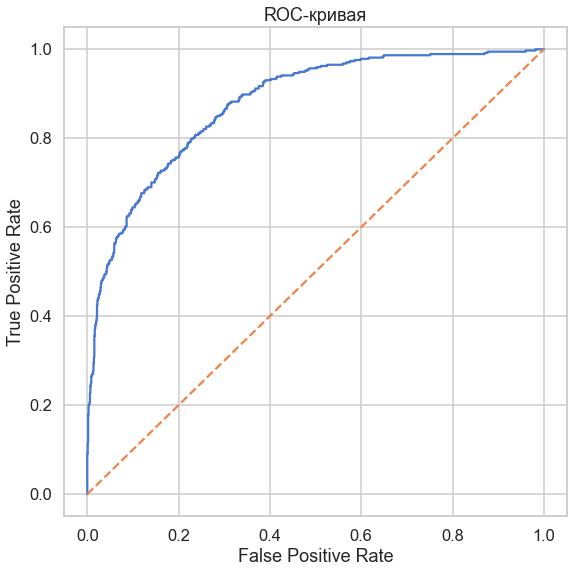

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, preds_proba)

plt.figure(figsize=(9, 9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Кривая выпуклая и симметричная. На основании этой кривой сложно сказать, нужно ли сдвигать пороговое значение вероятности. Рассмотрим матрицы ошибок для разных порогов.

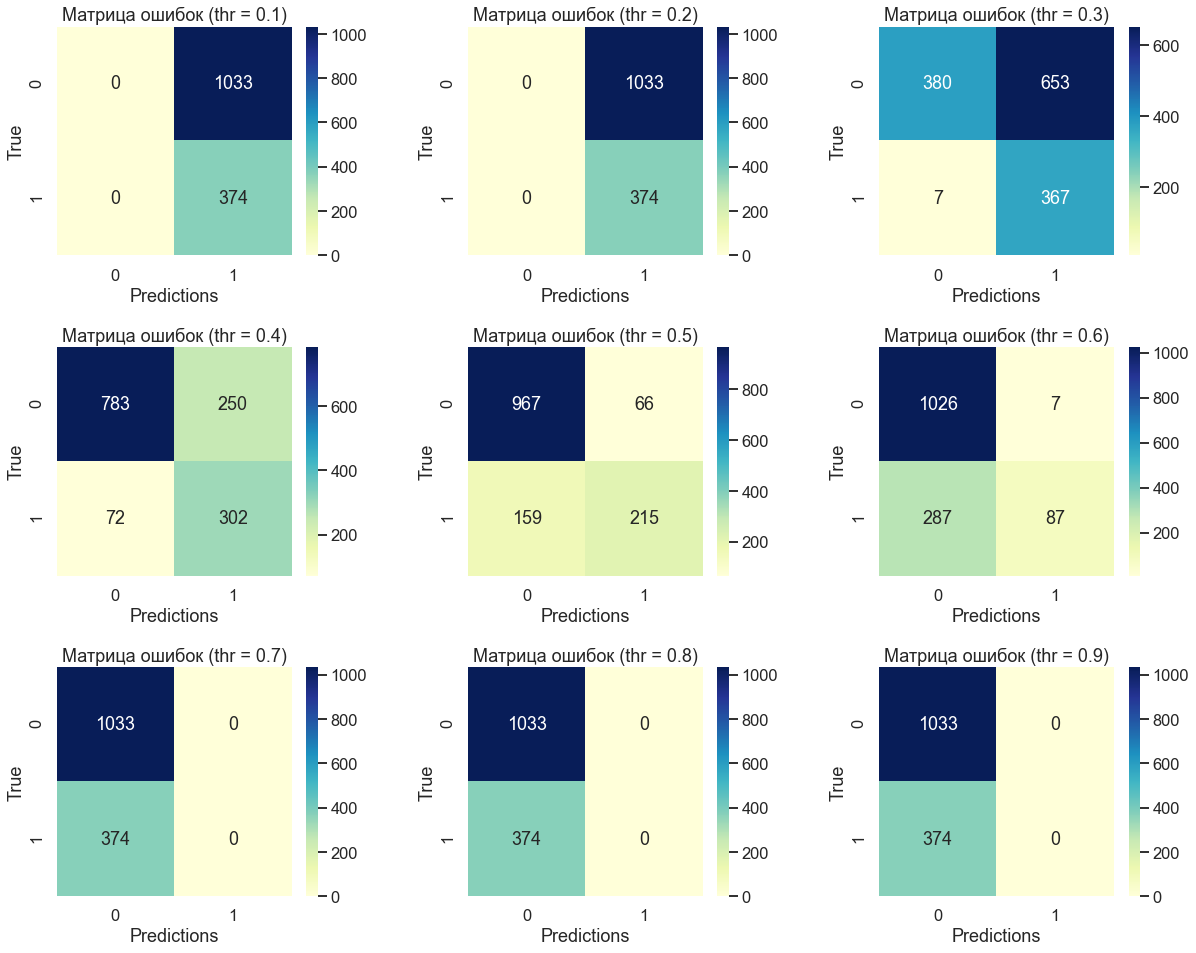

In [57]:
f, ax = plt.subplots(3, 3, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
f.set_figheight(16)
f.set_figwidth(20)
i = 0
j = 0
for thr in np.arange(0.1, 1, 0.1):
    sns.heatmap(
        confusion_matrix(y_test, preds_proba >= thr), 
        annot = True, 
        cmap = 'YlGnBu',
        fmt = 'd',
        ax = ax[i,j]
    )
    ax[i,j].set_xlabel('Predictions')
    ax[i,j].set_ylabel('True')
    ax[i,j].set_title('Матрица ошибок (thr = ' + str(round(thr, 1)) + ')')
    
    if j == 2:
        j = 0
        i += 1
    else:
        j += 1

plt.show()

С увеличением порога удаётся верно находить большее количество клиентов, которые не собираются уходить, при этом количество верно найденных целевых уходящих клиентов уменьшается. Если уменьшать порог для увеличения количества найденных уходящих клиентов, увеличивается количество тех клиентов, которые не собирались уходить, но которых модель пометила как уходящих. Зато уменьшается количество таких клиентов, которые собираются уйти, но которых модель не нашла. Чтобы принять решение о пороговом значении, нужно понимать, что дороже: дать части клиентов уйти или раздать лишние скидочные купоны. При стандартном пороге в 0.5 количество ложно отрицательных (тех, кого не нашла модель и кто уйдёт) более чем в два раза больше ложно положительных (тех, кто не собирался уходить, но получит купон).

**Вывод**

Лучшая модель - стек из трёх моделей - была протестирована на тестовой выборке. Итогавая метрика ROC-AUC=0.878, при этом значение accuracy=0.84. При стандартном пороговом значении вероятности 0.5 количество ложно отрицательных решений модели более чем в два раза больше количества ложно положительных.

## Анализ результатов

По итогам работы модели можно разделить выборку на 4 части:
- TP - true positive - клиент собирался уйти, и модель нашла его
- TN - true negative - клиент не собирался уходить, и модель поняла это
- FP - false positive - клиент не собирался уходить, но модель решила, что он уйдёт
- FN - false negative - клиент собирался уйти, но модель его не нашла

Если разделить количество объектов в каждой группе на общее количество объектов в тестовой выборке, можно получить вероятность попадания клиента в ту или иную группу. Обозначим эти вероятности те ми же сокращениями: TP, TN, FP, FN.

Пусть S - это прибыль, которую приносят клиенты, а k - это затраты на скидочные купоны. Без акции с купонами клиенты, которые собираются уйти, - уйдут, и прибыль будет такой:

$TN*S + FP*S - TP*S - FN*S$

Если провести акцию, TP-клиенты останутся, но FP-клиенты получат купон просто так, из-за ошибки в расчётах. Прибыль будет такой:

$TN*S + FP*S - FP*k + TP*S - TP*k - FN*S$

Если вычесть из второго выражения первое, получится следующее:

$2*TP*S - FP*k - TP*k$

Чтобы увеличить прибыль, эта разница должна быть положительной.

$2*TP*S - FP*k - TP*k > 0$

$2*TP*S > (TP + FP)*k$


$k < 2*S*{TP \over TP + FP}$

$k < 2*S*precision$

Размер купона ограничен точностью модели и прибылью, которую мы получим от клиента. Мы не знаем, на сколько сможем его задержать, и минимум, на который можно рассчитывать, - следующий платёж. Поэтому пороговое значение стоимости купона - удвоенная точность, умноженная на размер платежа клиента.

Чтобы акция была выгодна, нужно максимизировать значение этого выражения:

$2*S*precision - k$

Т.е. чем выше точность, тем выше прибыль. Нужно максимизировать TP и минимизировать FP, но при этом увеличится FN, что уменьшит итоговую прибыль:

$TN*S + FP*S - FP*k + TP*S - TP*k - FN*S$

- $TN*S + FP*S$ - положительные слогаемые
- $TP*S - TP*k$ - целевая аудитория - клиенты, которых мы хотим удержать
- $-FP*k - FN*S$ - сопутствующие расходы из-за ошибок модели

Значение S можно считать больше k, а если удастся задержать клиента надолго, то - значительно больше. Поэтому уменьшение FN выгоднее, чем уменьшение FP. 

Если для расчёта порогового значения k важна была точность, то для увеличения прибыли важнее полнота. Посмотрим на кривую Precision-Recall.

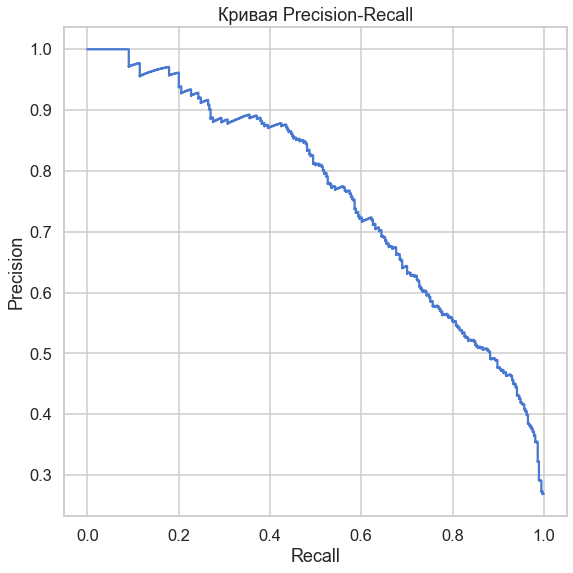

In [58]:
plt.figure(figsize=(9, 9))

precision, recall, thresholds = precision_recall_curve(y_test, preds_proba)

plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.show()

Чем выше recall, тем больше уходящих клиентов мы сможем найти и тем ниже будет значение precision, а значит снизится стоимость купона и его привлекательность для клиента. Оптимальное пороговое значение для модели находится в правом нижнем углу графика. Установим его равным 0.4: TP > FP, при этом значение FN достаточно низкое.

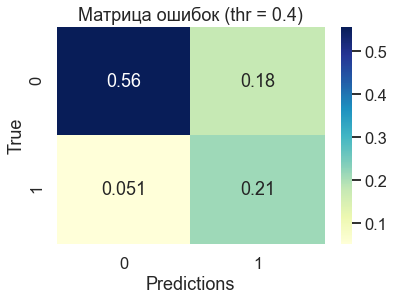

precision = 0.55
recall = 0.81


In [59]:
matrix_tfpn = confusion_matrix(y_test, preds_proba >= 0.4)

sns.heatmap(matrix_tfpn / y_test.shape[0], annot = True, cmap = 'YlGnBu')
plt.xlabel('Predictions')
plt.ylabel('True')
plt.title('Матрица ошибок (thr = 0.4)')
plt.show()

print('precision = {:.2f}'.format(matrix_tfpn[1,1] / (matrix_tfpn[1,1] + matrix_tfpn[0,1])))
print('recall = {:.2f}'.format(matrix_tfpn[1,1] / (matrix_tfpn[1,1] + matrix_tfpn[1,0])))

При этом 5.1% клиентов окажутся теми, кто собирается уйти и не получит промо купон.

**Вывод**

При условии, что ожидаемая прибыль от клиента выше стоимости купона, ложно отрицательные решения модели стоят дороже ложно положительных. Поэтому оптимально установить пороговое значение вероятности 0.4, при котором количество ложно отрицательных значений снижено, а увеличившееся при этом количество ложно положительных остаётся меньше, чем количество верно найденных уходящих клиентов.

Получившаяся точность равна 0.55, поэтому стоимость купона ограничена так:

$k < 2*S*precision$

$k < 1.1 * S$

## Выводы

В качестве исходных данных дана информация о пользователях в четырёх таблицах: информация о договоре, персональная информация, информация об интернет-услугах и информация об услугах телефонии. Необходимо сделать прогноз, собирается ли уйти клиент, чтобы предложить ему промо купон.

Данные были проанализированы и сведены в единую таблицу. Клиенты, которые уже ушли, помечены как положительные объекты. Выяснилось, что данные не сбалансированы: положительных объектов 26.5%. Анализ показал, что клиенты либо уходят сразу, либо задерживаются надолго. Дольше остаются те клиенты, у которых оплата по договору за два года, а не за месяц, есть доп. услуги, настроен автоплатёж и есть постоянный партнёр. У большинства клиентов баланс счёта близок, но не равен нулю, при этом есть клиенты с больши долгом и с большим депозитом.

Оценка взаимосвязи признаков показала, что сумма, уплаченная клиентом за всё время, сильно коррелирует с ежемесячной оплатой и количеством месяцев, поэтому для избежания мультиколлинеарности такая сумма была исключена при обучении модели. Кроме того, анализ показал, что гендер не коррелирует с другими признаками и имеет нулевую объясняющую способность для целевого признака. Поэтому гендер также был исключён из рассмотрения.

Среди пользователей выделяется 7 потребительских групп: есть два типа телефонии и два типа интернета - это образует 4 группы, плюс две группы тех, у кого нет интернета, но разные услуги телефонии, и одна группа людей без телефона - у всех у них DSL интернет. Поэтому пользователи были кластеризованы с помощью модели k-means. Кроме того, с помощью метода главных компонент из числовых признаков были получены новые, дополнительные.

Датасет был разделён на обучающую и тестовую части. В качестве теста выделено 20% с сохранением баланса классов. Тестовая часть на кросс-валидации была разделена на 4 части - при этом размер валидационной выборки равен тестовой. Чтобы избежать утечку данных, был написан класс для преобразования признаков: fit_transform для обучающей выборки и transform для валидационной и тесовой.

Для обучения были взяты три модели: логистическая регрессия, случайный лес и градиентный бустинг. Для каждой из них были подобраны оптимальные гиперпараметры на кросс-валидации. Все модели превзошли dummy-модель, лучшее значение ROC-AUC показал градиентный бустинг, при этом другие модели отстали незначительно.

Для борьбы с дисбалансом были опробованы различные техники: увеличение количества положительных объектов, уменьшение количества отрицательных объектов, создание новых объектов с помощью модели - все они не позволили улучшить значение метрики на кросс-валидации.

Каждая из трёх моделей опирается на разное взаимодействие признаков. Чтобы воспользоваться преимуществом всех найденных зависимостей, была использована стек-модель RidgeClassifier, обученная на предсказанных моделями вероятностях.

Тестирование получившейся стек-модели показало хорошее значение метрики: ROC-AUC=0.878, при этом accuracy=0.84. При стандартном пороговом значении вероятности 0.5 количество ложно отрицательных ответов почти в два раза больше ложно положительных.

Если считать, что стоимость промо купона существенно ниже прибыли, которую принесёт оставшийся клиент, то можно сказать, что ложно отрицательные ответы стоят дороже ложно положительных. Поэтому пороговое значение вероятности нужно сдвинуть влево. При пороге 0.4 только 5.1% клиентов окажутся теми, кто собирается уйти, но не будет найден моделью. При этом 18% клиентов получат купон просто так. 